In [1]:
import os
import copy
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pymap3d as pm
from scipy.spatial.transform import Rotation
import math
from pathlib import Path
from utils import project_root

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

# Extrinsic calibrations and globals

In [3]:
# IMU rotational offset
imu_rot_off = np.array([0, 0, 1.5708]).reshape((3,1))

In [4]:
r_b2i = Rotation.from_euler('z', 1.5708, degrees=False)
R_b2i = r_b2i.as_matrix()

In [5]:
R_b2i

array([[-3.6732051e-06, -1.0000000e+00,  0.0000000e+00],
       [ 1.0000000e+00, -3.6732051e-06,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]])

In [6]:
# GPS translational offset
x_off = -0.01
y_off = 0
z_off = 2.13
# gps_off = np.array([x_off, y_off, z_off]).reshape((3,1))
gps_off = np.zeros((3,1))

In [7]:
# seq: {‘X’, ‘Y’, ‘Z’} for intrinsic rotations, or {‘x’, ‘y’, ‘z’} for extrinsic rotations
# Wikipedia: The three elemental rotations may be extrinsic (rotations about the axes xyz 
# of the original coordinate system, which is assumed to remain motionless), or intrinsic 
# (rotations about the axes of the rotating coordinate system XYZ, 
# solidary with the moving body, which changes its orientation after each elemental rotation).
rot_order = 'xyz'

In [8]:
GRAV = 9.80665

# Topic Covariance matrices

In [9]:
# GPS position_covariance:
gps_pos_cov = [[0.019599999999999996, 0, 0],
               [0, 0.019599999999999996, 0],
               [0, 0, 0.31359999999999993]]

In [10]:
# IMU covariances (noise) from /ouster/imu topic
lin_acc_cov = [[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]
ang_vel_cov = [[0.0006, 0, 0],
              [0, 0.0006, 0],
              [0, 0, 0.0006]]

# Helper functions

## Stolen

In [11]:
_AXES2TUPLE = {
    'sxyz': (0, 0, 0, 0), 'sxyx': (0, 0, 1, 0), 'sxzy': (0, 1, 0, 0),
    'sxzx': (0, 1, 1, 0), 'syzx': (1, 0, 0, 0), 'syzy': (1, 0, 1, 0),
    'syxz': (1, 1, 0, 0), 'syxy': (1, 1, 1, 0), 'szxy': (2, 0, 0, 0),
    'szxz': (2, 0, 1, 0), 'szyx': (2, 1, 0, 0), 'szyz': (2, 1, 1, 0),
    'rzyx': (0, 0, 0, 1), 'rxyx': (0, 0, 1, 1), 'ryzx': (0, 1, 0, 1),
    'rxzx': (0, 1, 1, 1), 'rxzy': (1, 0, 0, 1), 'ryzy': (1, 0, 1, 1),
    'rzxy': (1, 1, 0, 1), 'ryxy': (1, 1, 1, 1), 'ryxz': (2, 0, 0, 1),
    'rzxz': (2, 0, 1, 1), 'rxyz': (2, 1, 0, 1), 'rzyz': (2, 1, 1, 1)}

_NEXT_AXIS = [1, 2, 0, 1]

_EPS = np.finfo(float).eps * 4.0

In [12]:
def unit_vector(data, axis=None, out=None):
    """Return ndarray normalized by length, i.e. Euclidean norm, along axis.
    >>> v0 = numpy.random.random(3)
    >>> v1 = unit_vector(v0)
    >>> numpy.allclose(v1, v0 / numpy.linalg.norm(v0))
    True
    >>> v0 = numpy.random.rand(5, 4, 3)
    >>> v1 = unit_vector(v0, axis=-1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=2)), 2)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = unit_vector(v0, axis=1)
    >>> v2 = v0 / numpy.expand_dims(numpy.sqrt(numpy.sum(v0*v0, axis=1)), 1)
    >>> numpy.allclose(v1, v2)
    True
    >>> v1 = numpy.empty((5, 4, 3))
    >>> unit_vector(v0, axis=1, out=v1)
    >>> numpy.allclose(v1, v2)
    True
    >>> list(unit_vector([]))
    []
    >>> list(unit_vector([1]))
    [1.0]
    """
    if out is None:
        data = np.array(data, dtype=np.float64, copy=True)
        if data.ndim == 1:
            data /= math.sqrt(np.dot(data, data))
            return data
    else:
        if out is not data:
            out[:] = np.array(data, copy=False)
        data = out
    length = np.atleast_1d(np.sum(data*data, axis))
    np.sqrt(length, length)
    if axis is not None:
        length = np.expand_dims(length, axis)
    data /= length
    if out is None:
        return data

In [13]:
def rotation_matrix(angle, direction, point=None):
    """Return matrix to rotate about axis defined by point and direction.
    >>> R = rotation_matrix(math.pi/2, [0, 0, 1], [1, 0, 0])
    >>> numpy.allclose(numpy.dot(R, [0, 0, 0, 1]), [1, -1, 0, 1])
    True
    >>> angle = (random.random() - 0.5) * (2*math.pi)
    >>> direc = numpy.random.random(3) - 0.5
    >>> point = numpy.random.random(3) - 0.5
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(angle-2*math.pi, direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> R0 = rotation_matrix(angle, direc, point)
    >>> R1 = rotation_matrix(-angle, -direc, point)
    >>> is_same_transform(R0, R1)
    True
    >>> I = numpy.identity(4, numpy.float64)
    >>> numpy.allclose(I, rotation_matrix(math.pi*2, direc))
    True
    >>> numpy.allclose(2, numpy.trace(rotation_matrix(math.pi/2,
    ...                                               direc, point)))
    True
    """
    sina = math.sin(angle)
    cosa = math.cos(angle)
    direction = unit_vector(direction[:3])
    # rotation matrix around unit vector
    R = np.diag([cosa, cosa, cosa])
    R += np.outer(direction, direction) * (1.0 - cosa)
    direction *= sina
    Rt = np.array([[ 0.0,         -direction[2],  direction[1]],
                   [ direction[2], 0.0,           -direction[0]],
                   [-direction[1], direction[0],  0.0]])
    np.add(R, Rt, out=R, casting="unsafe")
    M = np.identity(4)
    M[:3, :3] = R
    if point is not None:
        # rotation not around origin
        point = np.array(point[:3], dtype=np.float64, copy=False)
        M[:3, 3] = point - np.dot(R, point)
    return M

In [14]:
def euler_from_matrix(matrix, axes='sxyz'):
    """Return Euler angles from rotation matrix for specified axis sequence.
    axes : One of 24 axis sequences as string or encoded tuple
    Note that many Euler angle triplets can describe one matrix.
    >>> R0 = euler_matrix(1, 2, 3, 'syxz')
    >>> al, be, ga = euler_from_matrix(R0, 'syxz')
    >>> R1 = euler_matrix(al, be, ga, 'syxz')
    >>> numpy.allclose(R0, R1)
    True
    >>> angles = (4*math.pi) * (numpy.random.random(3) - 0.5)
    >>> for axes in _AXES2TUPLE.keys():
    ...    R0 = euler_matrix(axes=axes, *angles)
    ...    R1 = euler_matrix(axes=axes, *euler_from_matrix(R0, axes))
    ...    if not numpy.allclose(R0, R1): print(axes, "failed")
    """
    try:
        firstaxis, parity, repetition, frame = _AXES2TUPLE[axes.lower()]
    except (AttributeError, KeyError):
        _TUPLE2AXES[axes]  # validation
        firstaxis, parity, repetition, frame = axes

    i = firstaxis
    j = _NEXT_AXIS[i+parity]
    k = _NEXT_AXIS[i-parity+1]

    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    if repetition:
        sy = math.sqrt(M[i, j]*M[i, j] + M[i, k]*M[i, k])
        if sy > _EPS:
            ax = math.atan2( M[i, j],  M[i, k])
            ay = math.atan2( sy,       M[i, i])
            az = math.atan2( M[j, i], -M[k, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2( sy,       M[i, i])
            az = 0.0
    else:
        cy = math.sqrt(M[i, i]*M[i, i] + M[j, i]*M[j, i])
        if cy > _EPS:
            ax = math.atan2( M[k, j],  M[k, k])
            ay = math.atan2(-M[k, i],  cy)
            az = math.atan2( M[j, i],  M[i, i])
        else:
            ax = math.atan2(-M[j, k],  M[j, j])
            ay = math.atan2(-M[k, i],  cy)
            az = 0.0

    if parity:
        ax, ay, az = -ax, -ay, -az
    if frame:
        ax, az = az, ax
    return np.array([ax, ay, az]).reshape((3,1))

In [15]:
def quaternion_from_matrix(matrix, isprecise=False):
    """Return quaternion from rotation matrix.
    If isprecise is True, the input matrix is assumed to be a precise rotation
    matrix and a faster algorithm is used.
    >>> q = quaternion_from_matrix(numpy.identity(4), True)
    >>> numpy.allclose(q, [1, 0, 0, 0])
    True
    >>> q = quaternion_from_matrix(numpy.diag([1, -1, -1, 1]))
    >>> numpy.allclose(q, [0, 1, 0, 0]) or numpy.allclose(q, [0, -1, 0, 0])
    True
    >>> R = rotation_matrix(0.123, (1, 2, 3))
    >>> q = quaternion_from_matrix(R, True)
    >>> numpy.allclose(q, [0.9981095, 0.0164262, 0.0328524, 0.0492786])
    True
    >>> R = [[-0.545, 0.797, 0.260, 0], [0.733, 0.603, -0.313, 0],
    ...      [-0.407, 0.021, -0.913, 0], [0, 0, 0, 1]]
    >>> q = quaternion_from_matrix(R)
    >>> numpy.allclose(q, [0.19069, 0.43736, 0.87485, -0.083611])
    True
    >>> R = [[0.395, 0.362, 0.843, 0], [-0.626, 0.796, -0.056, 0],
    ...      [-0.677, -0.498, 0.529, 0], [0, 0, 0, 1]]
    >>> q = quaternion_from_matrix(R)
    >>> numpy.allclose(q, [0.82336615, -0.13610694, 0.46344705, -0.29792603])
    True
    >>> R = random_rotation_matrix()
    >>> q = quaternion_from_matrix(R)
    >>> is_same_transform(R, quaternion_matrix(q))
    True
    >>> R = euler_matrix(0.0, 0.0, numpy.pi/2.0)
    >>> numpy.allclose(quaternion_from_matrix(R, isprecise=False),
    ...                quaternion_from_matrix(R, isprecise=True))
    True
    """
    M = np.array(matrix, dtype=np.float64, copy=False)[:4, :4]
    if isprecise:
        q = np.empty((4, ))
        t = np.trace(M)
        if t > M[3, 3]:
            q[0] = t
            q[3] = M[1, 0] - M[0, 1]
            q[2] = M[0, 2] - M[2, 0]
            q[1] = M[2, 1] - M[1, 2]
        else:
            i, j, k = 1, 2, 3
            if M[1, 1] > M[0, 0]:
                i, j, k = 2, 3, 1
            if M[2, 2] > M[i, i]:
                i, j, k = 3, 1, 2
            t = M[i, i] - (M[j, j] + M[k, k]) + M[3, 3]
            q[i] = t
            q[j] = M[i, j] + M[j, i]
            q[k] = M[k, i] + M[i, k]
            q[3] = M[k, j] - M[j, k]
        q *= 0.5 / math.sqrt(t * M[3, 3])
    else:
        m00 = M[0, 0]
        m01 = M[0, 1]
        m02 = M[0, 2]
        m10 = M[1, 0]
        m11 = M[1, 1]
        m12 = M[1, 2]
        m20 = M[2, 0]
        m21 = M[2, 1]
        m22 = M[2, 2]
        # symmetric matrix K
        K = np.array([[m00-m11-m22, 0.0,         0.0,         0.0],
                         [m01+m10,     m11-m00-m22, 0.0,         0.0],
                         [m02+m20,     m12+m21,     m22-m00-m11, 0.0],
                         [m21-m12,     m02-m20,     m10-m01,     m00+m11+m22]])
        K /= 3.0
        # quaternion is eigenvector of K that corresponds to largest eigenvalue
        w, V = np.linalg.eigh(K)
        q = V[[3, 0, 1, 2], np.argmax(w)]
    if q[0] < 0.0:
        np.negative(q, q)
    return q

In [16]:
def euler_from_quaternion(quaternion, axes='sxyz'):
    """Return Euler angles from quaternion for specified axis sequence.
    >>> angles = euler_from_quaternion([0.99810947, 0.06146124, 0, 0])
    >>> numpy.allclose(angles, [0.123, 0, 0])
    True
    """
    return euler_from_matrix(quaternion_matrix(quaternion), axes)

In [17]:
def quaternion_matrix(quaternion):
    """Return homogeneous rotation matrix from quaternion.
    >>> M = quaternion_matrix([0.99810947, 0.06146124, 0, 0])
    >>> numpy.allclose(M, rotation_matrix(0.123, [1, 0, 0]))
    True
    >>> M = quaternion_matrix([1, 0, 0, 0])
    >>> numpy.allclose(M, numpy.identity(4))
    True
    >>> M = quaternion_matrix([0, 1, 0, 0])
    >>> numpy.allclose(M, numpy.diag([1, -1, -1, 1]))
    True
    """
    q = copy.deepcopy(quaternion.flatten())
    n = np.dot(q, q)
    if n < _EPS:
        return np.identity(4)
    q *= math.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0], 0.0],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0], 0.0],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2], 0.0],
        [                0.0,                 0.0,                 0.0, 1.0]], dtype=np.float64)

In [18]:
def quaternion_multiply(quaternion1, quaternion0):
    """Return multiplication of two quaternions.
        quaternion1 x quaternion0
    >>> q = quaternion_multiply([4, 1, -2, 3], [8, -5, 6, 7])
    >>> numpy.allclose(q, [28, -44, -14, 48])
    True
    """
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1*x0 - y1*y0 - z1*z0 + w1*w0,
                     x1*w0 + y1*z0 - z1*y0 + w1*x0,
                    -x1*z0 + y1*w0 + z1*x0 + w1*y0,
                     x1*y0 - y1*x0 + z1*w0 + w1*z0], dtype=np.float64)

## Mine

In [19]:
# page 25, Sola's
def quat2matrix(q):
    qw, qx, qy, qz = q
    
    R = [[qw**2 + qx**2 - qy**2 - qz**2, 2*(qx*qy - qw*qz),             2*(qx*qz + qw*qy)],
         [2*(qx*qy + qw*qz),             qw**2 - qx**2 + qy**2 - qz**2, 2*(qy*qz - qw*qx)],
         [2*(qx*qz - qw*qy),             2*(qy*qz + qw*qx),             qw**2 - qx**2 - qy**2 + qz**2]]
    
    return np.array(R).reshape((3,3))

# as defined in Sola, page 6
# The product of two rotation quaternions will be equivalent to the rotation a2 + b2i + c2j + d2k (q1)
# followed by the rotation a1 + b1i + c1j + d1k (q0).
def quat_mult(p, q):
    pw, px, py, pz = p
    qw, qx, qy, qz = q
    
    q_w = pw*qw - px*qx - py*qy - pz*qz
    q_x = pw*qx + px*qw + py*qz - pz*qy
    q_y = pw*qy - px*qz + py*qw + pz*qx
    q_z = pw*qz + px*qy - py*qx + pz*qw
    
    retq = np.array([q_w, q_x, q_y, q_z]).reshape((4,1))

    return retq

def euler2quat(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_quat = rot.as_quat() # [x, y, z, w]
    
    retval = np.array([rot_quat[3], rot_quat[0], rot_quat[1], rot_quat[2]]).reshape((4,1)) # [w, x, y, z]
    
    return retval

def euler2matrix(e_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler(axis, e_in.flatten())

    # Convert to quaternions
    rot_matrix = rot.as_matrix().reshape((3,3))
        
    return rot_matrix

def quat2euler(q_in, axis=rot_order):
    q_in_ = np.array([q_in[1], q_in[2], q_in[3], q_in[0]]).reshape((4,1)) # [w, x, y, z] -> [x, y, z, w]
    
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_quat(q_in_.flatten()) # [x, y, z, w]

    # Convert to euler
    rot_euler = rot.as_euler(axis) # [x,y,z]
    
    return rot_euler.reshape((3,1))

def matrix2euler(R_in, axis=rot_order):
    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_matrix(R_in)

    # Convert to quaternions
    rot_e = rot.as_euler(axis).reshape((3,1))
        
    return rot_e

In [20]:
# the first derivative of a rotation matrix
def dR(axis, x):
    if axis == 'z':
        ret = np.array([[-np.sin(x), -np.cos(x), 0],
                      [np.cos(x), -np.sin(x), 0],
                      [0, 0, 0]]).reshape(3,3)
    else:
        raise
        
        
    return(ret)

In [327]:
################## TEST ##################

# time
dt = 0.5
# angular velocity
w = np.array([1.3, 0, 0.7]).reshape((3,1))

# euler angles
r1 = np.array([0, 0, 0]).reshape((3,1))
r2 = r1 + w*dt

# quaternions
q1 = euler2quat(r1)
print("q1: ", q1)

w_theta = w*dt
w_norm = np.linalg.norm(w_theta)
q_w = np.cos(w_norm/2)
q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
q2 = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

q_next = quat_mult(q1, q2)
r_next = quat2euler(q_next, "xyz")

print("From euler: ", np.rad2deg(r2))
print("From quaternions: ")
print("q2: ", q2)
print(np.rad2deg(r_next))

q1:  [[1.]
 [0.]
 [0.]
 [0.]]
From euler:  [[37.24225668]
 [ 0.        ]
 [20.05352283]]
From quaternions: 
q2:  [[0.932645  ]
 [0.31766991]
 [0.        ]
 [0.17105303]]
[[36.58944579]
 [-6.23904439]
 [18.7212655 ]]


# Simulate data

## True data

### Use polar kinematics to create 2d trajectory

In [22]:
# we are simulating a 2d trajectory with polar kinematics (heading and rotation)
x_0 = 0
y_0 = 0
vel_0 = 0
acc = 0.5
or_0 = 0.3
ang_vel = 0.2

positions = np.empty((0,3), float)
pol_velocities = np.empty((0,1), float)
cart_velocities = np.empty((0,3), float)
cart_velocities_w = np.empty((0,3), float)
orientations = np.empty((0,3), float)

t_real = np.linspace(0, 100, 10000)

t_prev = 0
x_prev = x_0
y_prev = y_0
vel_prev = vel_0
or_prev = or_0 # imitate the real IMU orientation
for t in t_real:
    # kinematics
    dt = t - t_prev
    # orientation
    or_next = or_prev + ang_vel*dt
    # translation
    # position
    if ang_vel != 0:
        x_next = x_prev + (2*vel_prev/ang_vel)*np.sin(ang_vel*dt/2)*np.cos(or_prev + ang_vel*dt/2)
        y_next = y_prev + (2*vel_prev/ang_vel)*np.sin(ang_vel*dt/2)*np.sin(or_prev + ang_vel*dt/2)
    else:
        x_next = x_0
        y_next = y_0
    pos_next = [x_next, y_next]
    #velocities
    vel_next = vel_prev + acc*dt
    # world frame
    vx_w = np.cos(or_next)*vel_next
    vy_w = np.sin(or_next)*vel_next
    v_w = np.array([vx_w, vy_w, 0]).reshape((3,1))
    # robot frame
    R = Rotation.from_euler('z', or_prev).as_matrix()
    v = R.T@v_w
    
    # save position, velocity, orientation
    positions = np.append(positions, [[x_next, y_next, 0]], axis=0)
    pol_velocities = np.append(pol_velocities, vel_next)
    cart_velocities_w = np.append(cart_velocities_w, v_w.T, axis=0)
    cart_velocities = np.append(cart_velocities, v.T, axis=0)
    orientations = np.append(orientations, [[0, 0, or_next]], axis=0)
    
    # move to the next iteration
    t_prev = t
    x_prev = x_next
    y_prev = y_next
    vel_prev = vel_next
    or_prev = or_next


# now iterate over the existing trajectory and calculate the angular velocity and linear acceleration
w_list = np.array([0, 0, 0.2]).reshape((1,3)) 
a_list = np.array([0.5, 0, GRAV]).reshape((1,3))
for i in range(1, len(t_real)):
    dt = t_real[i] - t_real[i-1]
    w = (orientations[i] - orientations[i-1])/dt
    
    ori = orientations[i]
    R = Rotation.from_euler('z', ori[2]).as_matrix()
    
    a = (cart_velocities_w[i] - cart_velocities_w[i-1])/dt
    a[2] = a[2] + GRAV
    
    w_list = np.append(w_list, np.array(w).reshape((1,3)), axis=0)
    a_list = np.append(a_list, np.array(a).reshape((1,3)), axis=0)
    
# make all orientations in the [-180, 180] degrees range
orientations = orientations%(2*math.pi)
for o in orientations:
    if o[2] > math.pi:
        o[2] = o[2] - 2*math.pi

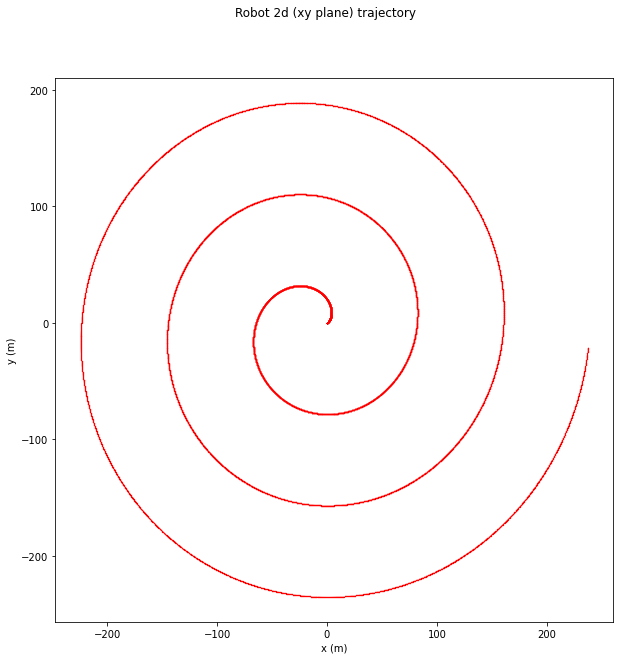

In [23]:
plt.plot(positions[:,0], positions[:,1], "r-x", linewidth=0.2, markersize=0.7)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("Robot 2d (xy plane) trajectory")
plt.show()

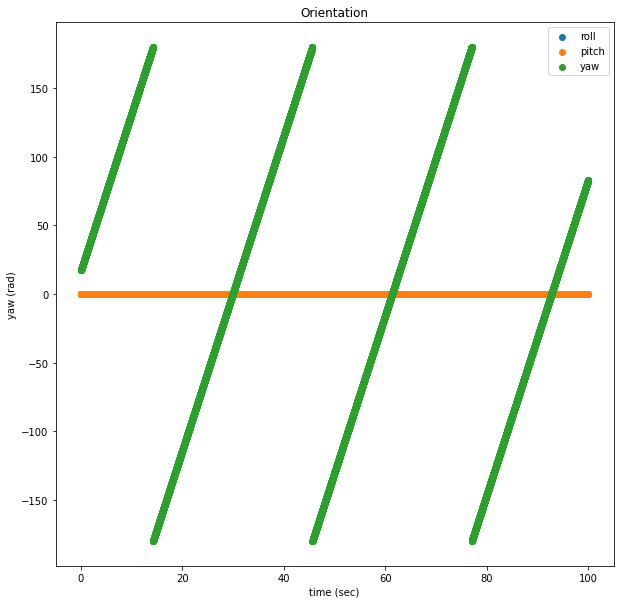

In [24]:
plt.scatter(t_real, np.rad2deg(orientations[:,0]), label="roll")
plt.scatter(t_real, np.rad2deg(orientations[:,1]), label="pitch")
plt.scatter(t_real, np.rad2deg(orientations[:,2]), label="yaw")

plt.xlabel("time (sec)")
plt.ylabel("yaw (rad)")
plt.title("Orientation")
plt.legend()
plt.show()

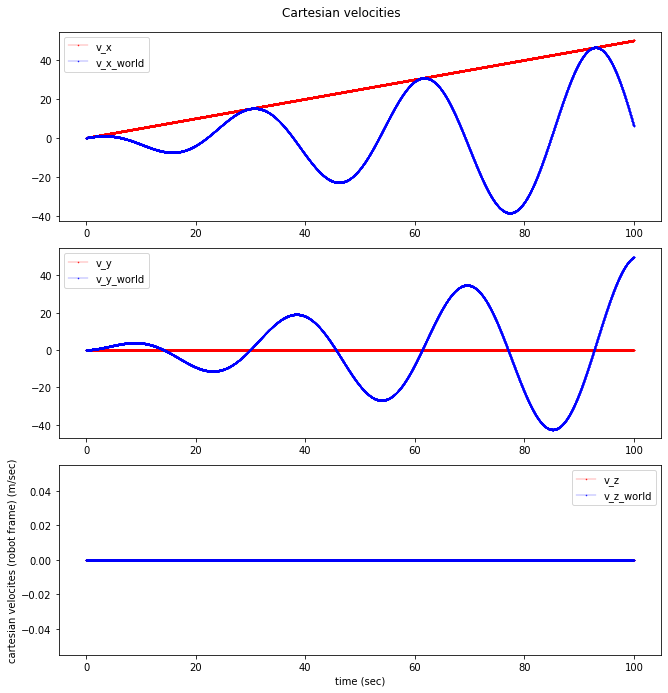

In [25]:
fig, axs = plt.subplots(3)

axs[0].plot(t_real, cart_velocities[:,0], 'r-o', markersize=0.5, linewidth=0.3, label="v_x")
axs[1].plot(t_real, cart_velocities[:,1], 'r-o', markersize=0.5, linewidth=0.3, label="v_y")
axs[2].plot(t_real, cart_velocities[:,2], 'r-o', markersize=0.5, linewidth=0.3, label="v_z")

axs[0].plot(t_real, cart_velocities_w[:,0], 'b-o', markersize=0.5, linewidth=0.3, label="v_x_world")
axs[1].plot(t_real, cart_velocities_w[:,1], 'b-o', markersize=0.5, linewidth=0.3, label="v_y_world")
axs[2].plot(t_real, cart_velocities_w[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="v_z_world")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("cartesian velocites (robot frame) (m/sec)")
plt.suptitle("Cartesian velocities")
plt.show()

Angular velocity: [[0.  0.  0.2]
 [0.  0.  0.2]
 [0.  0.  0.2]
 ...
 [0.  0.  0.2]
 [0.  0.  0.2]
 [0.  0.  0.2]]


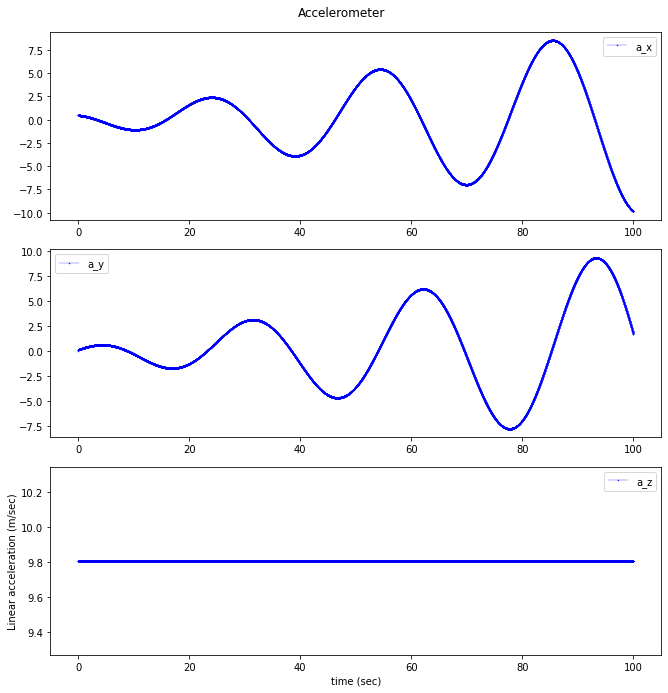

In [26]:
print(f"Angular velocity: {w_list}")

fig, axs = plt.subplots(3)

axs[0].plot(t_real, a_list[:,0], 'b-o', markersize=0.5, linewidth=0.3, label="a_x")
axs[1].plot(t_real, a_list[:,1], 'b-o', markersize=0.5, linewidth=0.3, label="a_y")
axs[2].plot(t_real, a_list[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="a_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("Linear acceleration (m/sec)")
plt.suptitle("Accelerometer")
plt.show()

### Recreate trajectory from quaternion kinematics

In [27]:
# we are simulating a 2d trajectory with standard 3d kinematics
p_0 = np.array([0, 0, 0]).reshape((3,1))
v_0 = np.array([0, 0, 0]).reshape((3,1))
q_0 = euler2quat(np.array([0, 0, or_0]))#np.array([ 1., 0., 0., 0.]).reshape((4,1)) # in quaternions : w,x,y,z
g = np.array([0, 0, -GRAV]).reshape((3,1))

positions = np.empty((0,3), float)
velocities = np.empty((0,3), float)
orientations_q = np.empty((0,4), float)
orientations_e = np.empty((0,3), float)

t_real = np.linspace(0, 100, 10000) # 33

t_prev = 0
p_prev = p_0
v_prev = v_0
q_prev = q_0
# q_prev_ = np.array([q_prev[3], q_prev[0], q_prev[1], q_prev[2]]).reshape((-4,1))
theta_prev = euler_from_quaternion(q_prev.T)
for i, t in enumerate(t_real):
    # kinematics
    dt = t - t_prev
    
    # orientation - page 22, Sola's book
    w_m = w_list[i].reshape((3,1))
    angle = np.linalg.norm(w_m)
    axis = w_m/angle
    # acceleration
    acc = copy.deepcopy(a_list[i]).reshape((3,1))
    acc[2] = acc[2] - GRAV
    
    # 2nd way
    q_s = np.cos(angle*dt/2)
    q_xyz = axis*np.sin(angle*dt/2)
    q_w = np.hstack((q_s, q_xyz.flatten())).reshape((4,1))  
    
    # rotation
    # orientation
    q_next = quat_mult(q_prev, q_w)
    theta_next = euler_from_quaternion(q_next)
    
    # translation
    # position
    p_next = p_prev + v_prev*dt + 0.5*(acc)*(dt**2)
    # velocities
    v_next = v_prev + (acc)*dt
    
    # save position, velocity, orientation
    positions = np.append(positions, p_next.T, axis=0)
    velocities = np.append(velocities, v_next.T, axis=0)
    orientations_q = np.append(orientations_q, q_next.T, axis=0)
    orientations_e = np.append(orientations_e, theta_next.T, axis=0)
    
    # move to the next iteration
    t_prev = t
    p_prev = p_next
    v_prev = v_next
    q_prev = q_next

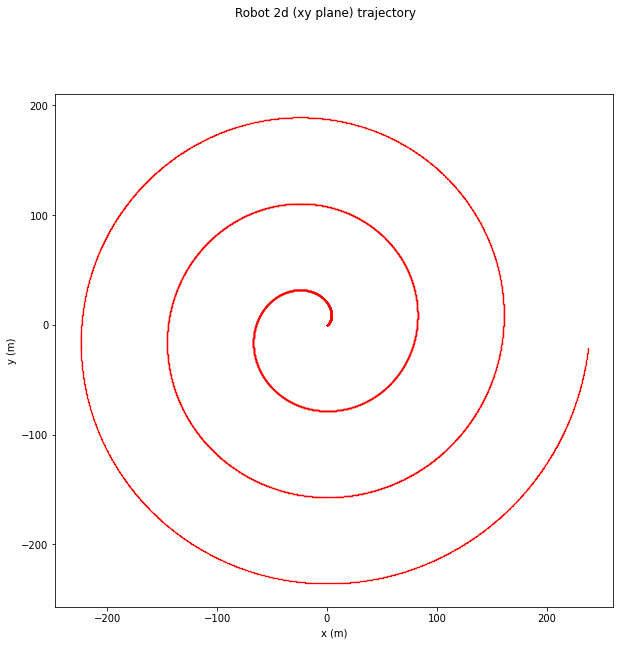

In [28]:
plt.plot(positions[:,0], positions[:,1], "r-x", linewidth=0.2, markersize=0.7)
plt.gca().set_aspect("equal")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("Robot 2d (xy plane) trajectory")
plt.show()

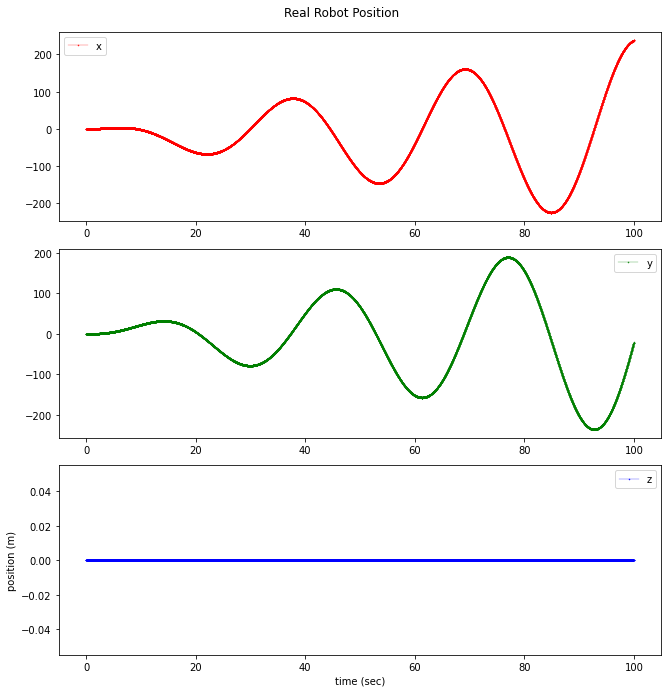

In [29]:
fig, axs = plt.subplots(3)

axs[0].plot(t_real, positions[:,0], 'r-o', markersize=0.5, linewidth=0.3, label="x")
axs[1].plot(t_real, positions[:,1], 'g-o', markersize=0.5, linewidth=0.3, label="y")
axs[2].plot(t_real, positions[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("position (m)")
plt.suptitle("Real Robot Position")
plt.show()

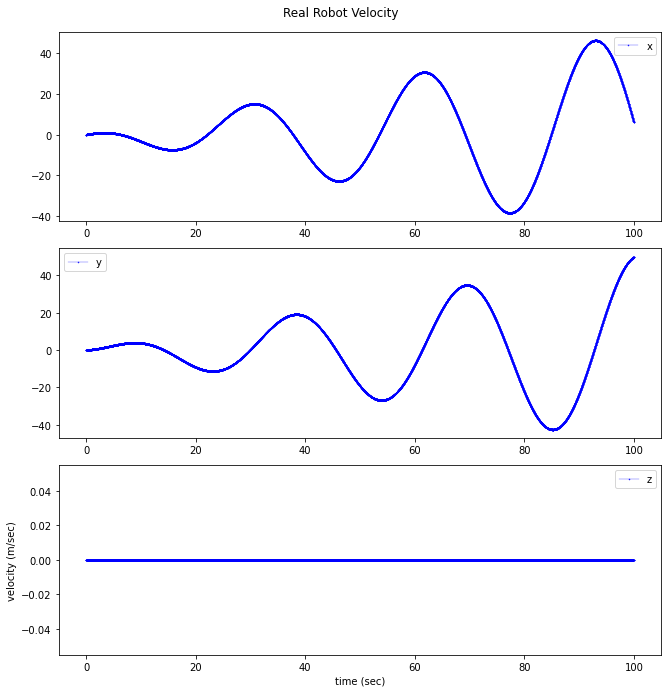

In [30]:
fig, axs = plt.subplots(3)

axs[0].plot(t_real, velocities[:,0], 'b-o', markersize=0.5, linewidth=0.3, label="x")
axs[1].plot(t_real, velocities[:,1], 'b-o', markersize=0.5, linewidth=0.3, label="y")
axs[2].plot(t_real, velocities[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("velocity (m/sec)")
plt.suptitle("Real Robot Velocity")
plt.show()

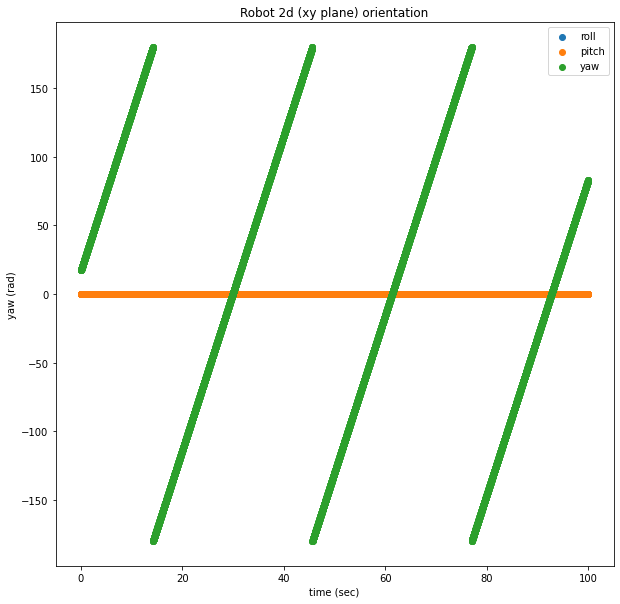

In [31]:
plt.scatter(t_real, np.rad2deg(orientations_e[:,0]), label="roll")
plt.scatter(t_real, np.rad2deg(orientations_e[:,1]), label="pitch")
plt.scatter(t_real, np.rad2deg(orientations_e[:,2]), label="yaw")

plt.xlabel("time (sec)")
plt.ylabel("yaw (rad)")
plt.title("Robot 2d (xy plane) orientation")
plt.legend()
plt.show()

## GPS, IMU sampling

In [32]:
t_gps = [] # sample gps every 0.1 second
t_imu = [] # sample IMU every 0.01 sec
for i, t in enumerate(t_real):
    if i%10 == 0 :
        t_gps.append(t)
    t_imu.append(t)
        
gps = np.empty((0,3), float)
imu_w = np.empty((0,3), float)
imu_a = np.empty((0,3), float)
i_gps = 0
i_imu = 0
for i, t in enumerate(t_real):
    if i_imu < len(t_imu):
        if t == t_imu[i_imu]:
            R_ori = euler2matrix(orientations[i])
            w_reading = R_ori.T@R_b2i@w_list[i] # IMU extrinsics
            a_reading = R_ori.T@R_b2i@a_list[i] 
            imu_w = np.append(imu_w, w_reading.reshape(1,3), axis=0)
            imu_a = np.append(imu_a, a_reading.reshape(1,3), axis=0)
            i_imu+=1
    if i_gps < len(t_gps):
        if t == t_gps[i_gps]:
            gps_reading = positions[i] + gps_off # GPS extrinsics
            gps = np.append(gps, positions[i].reshape(1,3), axis=0)
            i_gps+=1

## Add white noise + bias to GPS, IMU

In [33]:
# add noise to the gps signal
var_p = 0.0196
sigma_p = np.sqrt(var_p)
gps_x_wn = np.random.normal(0, sigma_p, len(gps))
gps_y_wn = np.random.normal(0, sigma_p, len(gps))
gps_z_wn = np.random.normal(0, sigma_p, len(gps))
gps_noise = copy.deepcopy(gps)
gps_noise[:,0] = gps_noise[:,0] + gps_x_wn
gps_noise[:,1] = gps_noise[:,1] + gps_y_wn
gps_noise[:,2] = gps_noise[:,2] + gps_z_wn

# add noise to the imu signal
var_w = 0.0006
sigma_w = np.sqrt(var_w)
var_a = 0.01
sigma_a = np.sqrt(var_a)
# angular velocity
imu_wx_wn = np.random.normal(0, sigma_w, len(imu_w))
imu_wy_wn = np.random.normal(0, sigma_w, len(imu_w))
imu_wz_wn = np.random.normal(0, sigma_w, len(imu_w))
imu_w_noise = copy.deepcopy(imu_w)
imu_w_noise[:,0] = imu_w_noise[:,0] + imu_wx_wn
imu_w_noise[:,1] = imu_w_noise[:,1] + imu_wy_wn
imu_w_noise[:,2] = imu_w_noise[:,2] + imu_wz_wn
# linear acceleration
imu_ax_wn = np.random.normal(0, sigma_a, len(imu_a))
imu_ay_wn = np.random.normal(0, sigma_a, len(imu_a))
imu_az_wn = np.random.normal(0, sigma_a, len(imu_a))
imu_a_noise = copy.deepcopy(imu_a)
imu_a_noise[:,0] = imu_a_noise[:,0] + imu_ax_wn
imu_a_noise[:,1] = imu_a_noise[:,1] + imu_ay_wn
imu_a_noise[:,2] = imu_a_noise[:,2] + imu_az_wn

# add bias to the IMU
imu_wx_bias = np.linspace(-0.01907755, -0.01907755, len(imu_wx_wn))
imu_wy_bias = np.linspace(0.01299578, 0.01299578, len(imu_wy_wn))
imu_wz_bias = np.linspace(-0.00510084, -0.00510084, len(imu_wz_wn))
imu_w_noise[:,0] = imu_w_noise[:,0] + imu_wx_bias
imu_w_noise[:,1] = imu_w_noise[:,1] + imu_wy_bias
imu_w_noise[:,2] = imu_w_noise[:,2] + imu_wz_bias

# imu_ax_bias = np.linspace(0, 1, len(imu_ax_wn))
imu_ax_bias = np.linspace(0.10895214, 0.10895214, len(imu_ax_wn))
imu_ay_bias = np.linspace(-0.80556905, -0.80556905, len(imu_ay_wn))
imu_az_bias = np.linspace(-0.09362127, -0.09362127, len(imu_az_wn))
imu_a_noise[:,0] = imu_a_noise[:,0] + imu_ax_bias
imu_a_noise[:,1] = imu_a_noise[:,1] + imu_ay_bias
imu_a_noise[:,2] = imu_a_noise[:,2] + imu_az_bias

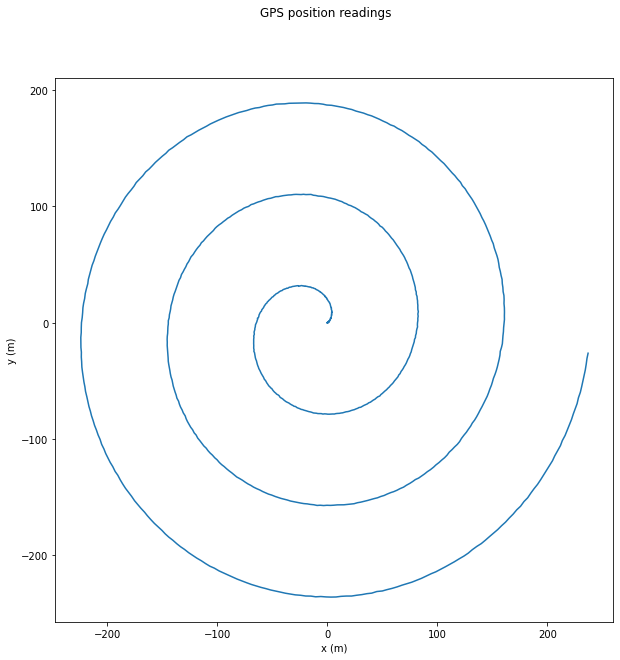

In [34]:
plt.plot(gps_noise[:,0], gps_noise[:,1])

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("GPS position readings")
plt.show()

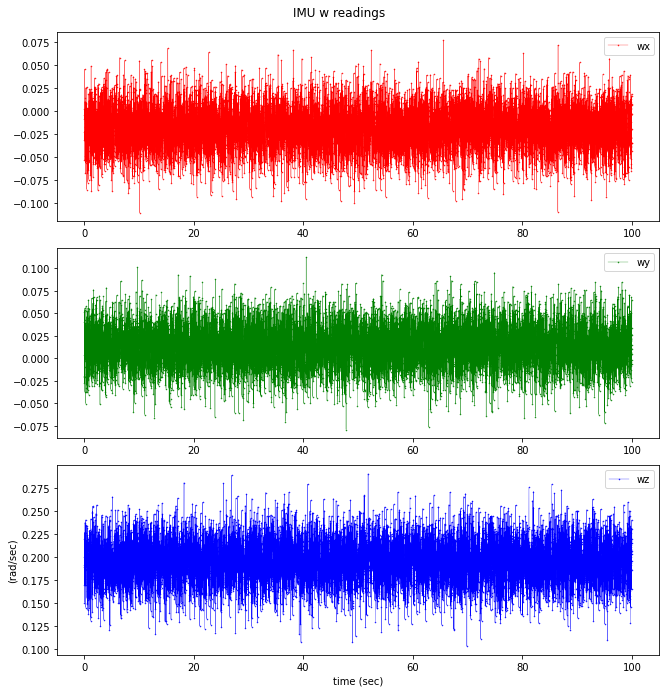

In [35]:
fig, axs = plt.subplots(3)

axs[0].plot(t_imu, imu_w_noise[:,0], 'r-o', markersize=0.5, linewidth=0.3, label="wx")
axs[1].plot(t_imu, imu_w_noise[:,1], 'g-o', markersize=0.5, linewidth=0.3, label="wy")
axs[2].plot(t_imu, imu_w_noise[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="wz")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(rad/sec)")
plt.suptitle("IMU w readings")
plt.show()

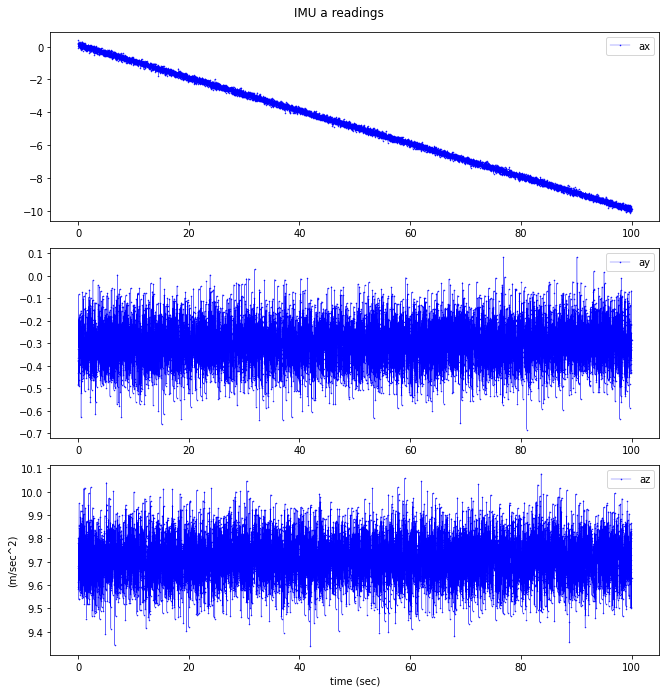

In [36]:
fig, axs = plt.subplots(3)

axs[0].plot(t_imu, imu_a_noise[:,0], 'b-o', markersize=0.5, linewidth=0.3, label="ax")
axs[1].plot(t_imu, imu_a_noise[:,1], 'b-o', markersize=0.5, linewidth=0.3, label="ay")
axs[2].plot(t_imu, imu_a_noise[:,2], 'b-o', markersize=0.5, linewidth=0.3, label="az")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("IMU a readings")
plt.show()

## Recreate trajectory from IMU readings

In [37]:
# we are simulating a 2d trajectory with standard 3d kinematics
p_0 = np.array([0, 0, 0]).reshape((3,1))
v_0 = np.array([0, 0, 0]).reshape((3,1))
q_0 = np.array([ 1., 0., 0., 0.]).reshape((4,1)) # in quaternions : w,x,y,z
g = np.array([0, 0, -GRAV]).reshape((3,1))

imu_p = np.empty((0,3), float)
imu_v = np.empty((0,3), float)
imu_q = np.empty((0,4), float)
imu_e = np.empty((0,3), float)

t_real = np.linspace(0, 100, 10000) # 33

t_prev = 0
p_prev = p_0
v_prev = v_0
q_prev = q_0
theta_prev = euler_from_quaternion(q_prev.T)
for i, t in enumerate(t_imu):
    R = R_b2i.T@quat2matrix(q_prev)
    
    # kinematics
    dt = t - t_prev
    
    # IMU readings
    # orientation - page 22, Sola's book
    w_m = imu_w[i].reshape((3,1))
    angle = np.linalg.norm(w_m)
    axis = w_m/angle
    # acceleration
    acc = imu_a[i].reshape((3,1))
    
    # rotation due to angular velocity
    q_s = np.cos(angle*dt/2)
    q_xyz = axis*np.sin(angle*dt/2)
    q_w = np.hstack((q_s, q_xyz.flatten())).reshape((4,1))  
    
    # rotation
    # orientation
    q_next = quat_mult(q_prev, q_w)
    theta_next = quat2euler(q_next)
    
    # translation
    # position
    p_next = p_prev + v_prev*dt + 0.5*(R@(acc) + g)*(dt**2)
    # velocities
    v_next = v_prev + (R@(acc) + g)*dt
    
    # save position, velocity, orientation
    imu_p = np.append(imu_p, p_next.T, axis=0)
    imu_v = np.append(imu_v, v_next.T, axis=0)
    imu_q = np.append(imu_q, q_next.T, axis=0)
    imu_e = np.append(imu_e, theta_next.T, axis=0)
    
    # move to the next iteration
    t_prev = t
    p_prev = p_next
    v_prev = v_next
    q_prev = q_next

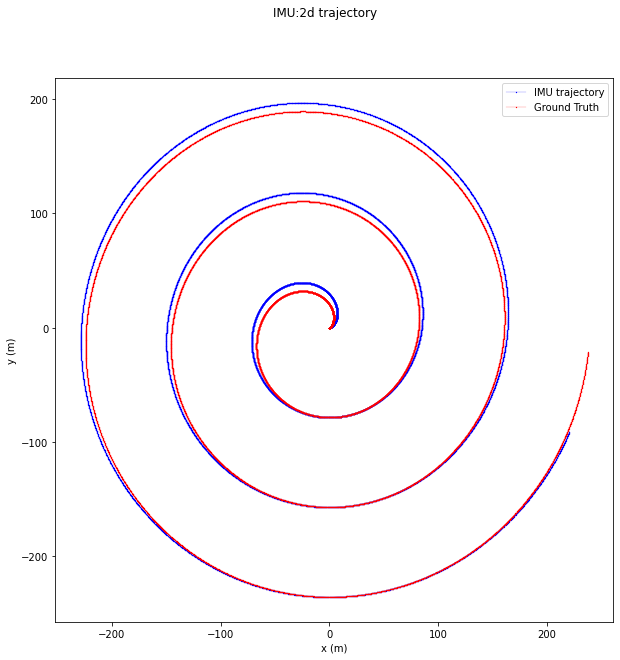

In [38]:
plt.plot(imu_p[:,0], imu_p[:,1], "b-x", linewidth=0.2, markersize=0.7, label="IMU trajectory")
plt.plot(positions[:,0], positions[:,1], "r-x", linewidth=0.2, markersize=0.7, label="Ground Truth")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.suptitle("IMU:2d trajectory")
plt.legend()
plt.show()

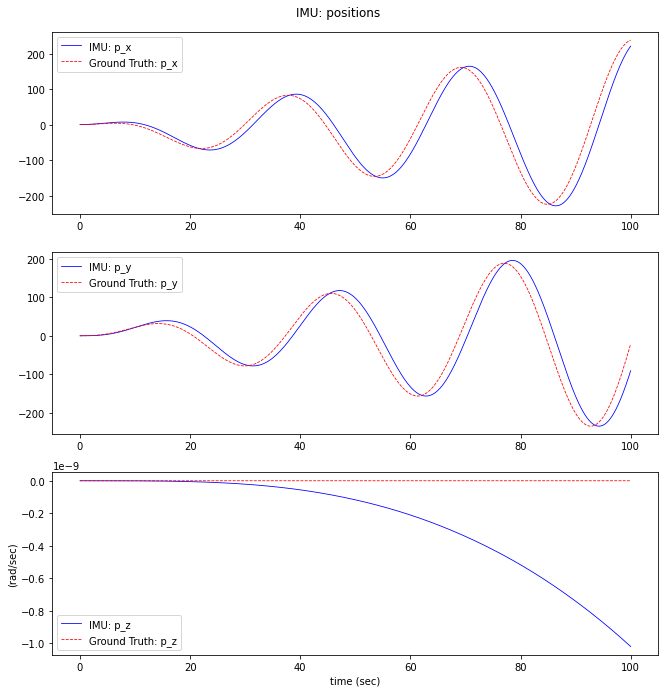

In [39]:
fig, axs = plt.subplots(3)

axs[0].plot(t_imu, imu_p[:,0], 'b-', linewidth=0.8, label="IMU: p_x")
axs[1].plot(t_imu, imu_p[:,1], 'b-', linewidth=0.8, label="IMU: p_y")
axs[2].plot(t_imu, imu_p[:,2], 'b-', linewidth=0.8, label="IMU: p_z")

axs[0].plot(t_real, positions[:,0], 'r--', linewidth=0.8, label="Ground Truth: p_x")
axs[1].plot(t_real, positions[:,1], 'r--', linewidth=0.8, label="Ground Truth: p_y")
axs[2].plot(t_real, positions[:,2], 'r--', linewidth=0.8, label="Ground Truth: p_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(rad/sec)")
plt.suptitle("IMU: positions")
plt.legend()
plt.show()

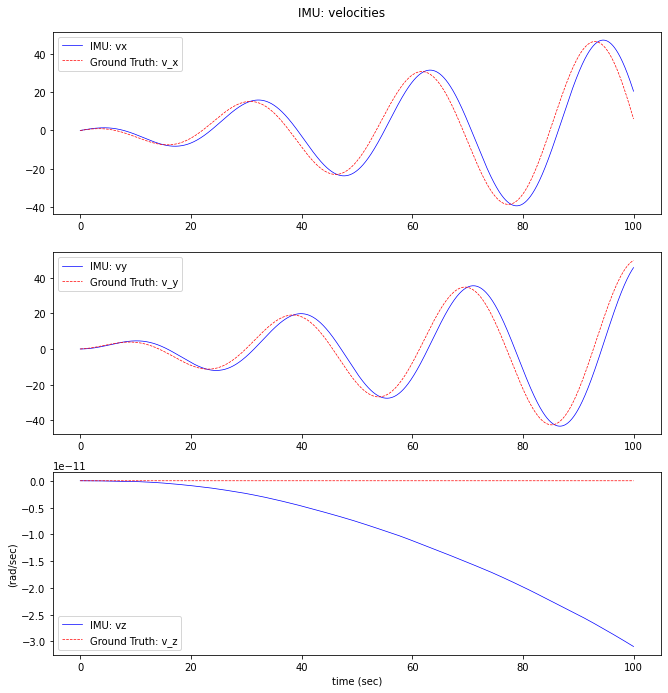

In [40]:
fig, axs = plt.subplots(3)

axs[0].plot(t_imu, imu_v[:,0], 'b-', linewidth=0.7, label="IMU: vx")
axs[1].plot(t_imu, imu_v[:,1], 'b-', linewidth=0.7, label="IMU: vy")
axs[2].plot(t_imu, imu_v[:,2], 'b-', linewidth=0.7, label="IMU: vz")

axs[0].plot(t_real, cart_velocities_w[:,0], 'r--', linewidth=0.7, label="Ground Truth: v_x")
axs[1].plot(t_real, cart_velocities_w[:,1], 'r--', linewidth=0.7, label="Ground Truth: v_y")
axs[2].plot(t_real, cart_velocities_w[:,2], 'r--', linewidth=0.7, label="Ground Truth: v_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(rad/sec)")
plt.suptitle("IMU: velocities")
plt.legend()
plt.show()

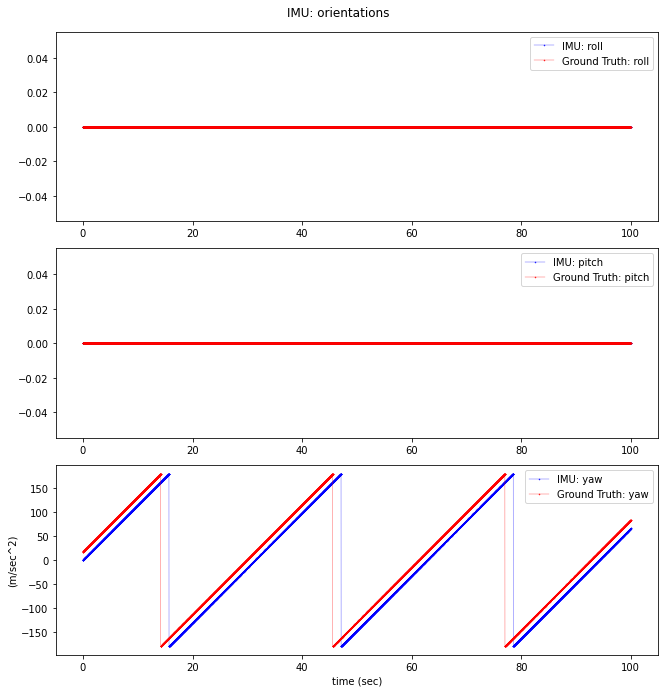

In [41]:
fig, axs = plt.subplots(3)

axs[0].plot(t_imu, np.rad2deg(imu_e[:,0]), 'b-o', markersize=0.5, linewidth=0.3, label="IMU: roll")
axs[1].plot(t_imu, np.rad2deg(imu_e[:,1]), 'b-o', markersize=0.5, linewidth=0.3, label="IMU: pitch")
axs[2].plot(t_imu, np.rad2deg(imu_e[:,2]), 'b-o', markersize=0.5, linewidth=0.3, label="IMU: yaw")

axs[0].plot(t_real, np.rad2deg(orientations[:,0]), 'r-o', 
            markersize=0.5, linewidth=0.3, label="Ground Truth: roll")
axs[1].plot(t_real, np.rad2deg(orientations[:,1]), 'r-o', 
            markersize=0.5, linewidth=0.3, label="Ground Truth: pitch")
axs[2].plot(t_real, np.rad2deg(orientations[:,2]), 'r-o', 
            markersize=0.5, linewidth=0.3, label="Ground Truth: yaw")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("IMU: orientations")
plt.show()

# IMU - GPS sensor fusion

Following "Error State Extended Kalman Filter Multi-Sensor Fusion for
Unmanned Aerial Vehicle Localization in GPS and Magnetometer
Denied Indoor Environments" by Lovro M. et al.

## Functions

### Nominal state : IMU

In [64]:
# update of the nominal state (ignores noise & inaccuracies) based on system dynamics
def nominal_state(dt, x_prev, a_imu, omega_imu):
    p_prev = x_prev[0:3]
    v_prev = x_prev[3:6]
    q_prev = x_prev[6:10]
    a_b = x_prev[10:13]
    omega_b = x_prev[13:16]
    g = x_prev[16:19]
    p_i = x_prev[19:22]
    q_i = x_prev[22:26]    
    # find the current robot rotation matrix
    R_robot = quat2matrix(q_prev)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T@R_robot
#     R = R_robot
    
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))   

    # apply dynamics to position, velocity and orientation
#     temp = dR_i2b@v_prev # should I include this term?
    p = p_prev + v_prev*dt + 0.5*(R@(a_imu-a_b) + g)*(dt**2)
    v = v_prev + (R @ (a_imu - a_b) + g)*dt
    
    q = quat_mult(q_prev, q_omega)    
    
    # the nominal state
    x_out = np.vstack((p, v, q, a_b, omega_b, g, p_i, q_i))
    
    return x_out

### Prediction ( Error state) : IMU

In [65]:
def predict(dt, x, dx_prev, P_prev, 
            a_imu, omega_imu):
    
    Fx = F_x(dt, x, a_imu, omega_imu)
    Fw = F_w()
    Qw = Q_w(dt)

#     dx = Fx @ dx_prev #+ Fw @ w # this is always zero!

    t1 = (Fx @ P_prev) @ Fx.T
    t2 = (Fw @ Qw) @ Fw.T

    P = t1 + t2 # this is the only term we are interested in
    
    return dx, P

In [66]:
# calculate state transition matrix (including drift - last 6 elements)
def F_x(dt, x, a_imu, omega_imu):
    # extract linear acceleration and angular velocity biases
    a_b = x[10:13]
    omega_b = x[13:16]
    # find the current robot rotation matrix
    q_ = x[6:10]
    R_robot = quat2matrix(q_)
    
    # extract the current Rotation (IMU frame rotation + robot rotation)
    R = R_b2i.T @ R_robot
#     R = R_robot
    
    # linear acceleration
    real_a = a_imu - a_b
    # angular velocity
    w_theta = R@(omega_imu - omega_b)*dt
    
    # extract dq from angular velocity
    w_norm = np.linalg.norm(w_theta)
    q_w = np.cos(w_norm/2)
    q_xyz = (w_theta/w_norm)*np.sin(w_norm/2)
    q_omega = np.hstack((q_w, q_xyz.flatten())).reshape((4,1))    
    
    # convert dq to rotation matrix
    Rw = quat2matrix(q_omega.flatten())

    # shortcuts
    A = skew(real_a)
    RA = R @ A
    
    F = np.zeros((24, 24))
    F[0:3, 0:3] = I3
    F[0:3, 3:6] = I3*dt
    
    F[3:6, 3:6] = I3
    F[3:6, 6:9] = -RA*dt
    F[3:6, 9:12] = -R*dt
    F[3:6, 15:18] = I3*dt
    
    F[6:9, 6:9] = Rw.T
    F[6:9, 12:15] = -I3*dt
    
    F[9:24, 9:24] = np.eye(15)
        
    return F

In [67]:
# calculate noise state transition matrix
def F_w():    
    M = np.zeros((24,12))
    M[3:6, 0:3] = I3
    M[6:9, 3:6] = I3
    M[9:12, 6:9] = I3
    M[12:15, 9:12] = I3

    return M

In [68]:
# calculate noise covariance
def Q_w(dt):
    
    Q = np.zeros((12,12))
    Q[0:3, 0:3] = var_v * I3 * dt**2
    Q[3:6, 3:6] = var_theta * I3 * dt**2
    Q[6:9, 6:9] = var_alpha * I3 * dt**2
    Q[9:12, 9:12] = var_omega * I3 * dt**2
    
    return Q

In [69]:
# page 17 - Solas
# calculate skew symmetric matrix of vector in se(3)
def skew(x):
    x = x.flatten()
    
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]]).reshape((3,3))

### True state : GPS

In [70]:
def true_state(x_in, dx):  
    p = x_in[0:3]
    v = x_in[3:6]
    q = x_in[6:10]
    a = x_in[10:13]
    w = x_in[13:16]
    g = x_in[16:19]
    p_i = x_in[19:22]
    q_i = x_in[22:26]
    
    dp = dx[0:3]
    dv = dx[3:6]
    dtheta = dx[6:9]
    dq = euler2quat(dtheta, rot_order)
    da = dx[9:12]
    dw = dx[12:15]
    dg = dx[15:18]
    dp_i = dx[18:21]
    dtheta_i = dx[21:24]
    dq_i = euler2quat(dtheta_i, rot_order)
    
    p_t = p + dp
    v_t = v + dv
    q_t = quat_mult(q, dq)
    a_t = a + da
    w_t = w + dw
    g_t = g + dg
    p_i_t = p_i + dp_i
    q_i_t = quat_mult(q_i, dq_i)
    
    x_out = np.vstack((p_t, v_t, q_t, a_t, w_t, g_t, p_i_t, q_i_t))

    return x_out

### Correction : GPS and other correction sensors/measurements

In [71]:
# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def correct(x, P, y_mu, V, flag):    
    # Kalman gain
    H = get_H(x, y_mu, flag) # jacobian
    K = (P @ H.T) @ np.linalg.inv(((H@P)@H.T) + V) # Kalman gain
    
    # error
    h = get_h(x, flag)
    innov = get_innov(x, y_mu, h, flag)
    dx = K @ innov
    
    # covariance update
    P = (np.eye(24) - (K@H)) @ P
    
    return innov, K, dx, P

In [72]:
def get_innov(x, mu, h, flag):
    if flag==0: # position measurement
        inno = mu - h
    elif flag==1: # orientation measuremnt
        e = quat2euler(h)
        R = quat2matrix(h)
        print("R.T@e: ", R.T@e)

        q_mu = euler2quat(mu)
        R_mu = quat2matrix(q_mu)
                
        # page 19, Solas
        R_inno = R.T@R_mu
        print("R.T: ", R.T)
        print("R_mu: ", R_mu)
        print("R_inno: ", R_inno)
        phi = np.arccos( (np.trace(R_inno) - 1)/2 )
        print("Phi: ", phi)
        u = v_func(R_inno - R_inno.T)/(2 * np.sin(phi))
        
        inno = u*phi
#         inno = matrix2euler(R_inno) - quat2euler(h)
        print("Innovation: ", inno)
    
    return inno

In [73]:
# TEST
R = Rotation.from_euler("z", 90, degrees=True).as_matrix().reshape((3,3))
p = np.array([10, 0, 0]).reshape((3,1))
p1 = R@p
p2 = R.T@p1

print(p, p1, p2)

[[10]
 [ 0]
 [ 0]] [[2.22044605e-15]
 [1.00000000e+01]
 [0.00000000e+00]] [[10.]
 [ 0.]
 [ 0.]]


In [74]:
# flag: 0 -> position sensor, 1 -> orientation sensor, 2 -> otherwise
def get_h(x, flag=0):        
    if flag == 0:
        p_t = x[0:3]
        p_i = x[19:22]
        q_i = x[22:26]
        R_qi = quat2matrix(q_i)
        
        ret = np.matmul(R_qi, p_t) + p_i
        
        return ret
    elif flag == 1:
        q_t = x[6:10]
        q_i = x[22:26]
        
        ret = quat_mult(q_i, q_t)

        return ret
    else:
        return x

In [75]:
def get_H(x, mu, flag):    
    J1 = Jac1(x, mu, flag)
    J2 = Jac2(x)
    J = J1 @ J2 

    return J

In [76]:
# page 19, solas
# this function is the reverse of the "skew" function
def v_func(R):
    return np.array([R[2,1], R[0,2], R[1,0]]).reshape((3,1))

In [77]:
# page 19, solas
# this function
def log_func(R):
    phi = np.arccos((np.trace(R) - 1)/2)
    u = v_func(R - R.T)/(2 * np.sin(phi))
    retval = skew(u*phi)
    
    return retval

In [78]:
############# Test ###############
v = np.array([1, 2, 3]).reshape(3,1)
print(v_func(skew(v)))
V = np.array([[0, -2, 3],
            [2, 0, -6],
            [-3, 6, 0]]).reshape(3,3)
print(skew(v_func(V)))

[[1]
 [2]
 [3]]
[[ 0 -2  3]
 [ 2  0 -6]
 [-3  6  0]]


### ESKF reset : GPS

In [79]:
def reset(dx, P):
    dtheta = dx[6:9]
    
    G = np.zeros((24,24))
    G[0:6, 0:6] = np.eye(6)
    G[6:9, 6:9] = I3 - skew(0.5*dtheta)
    G[9:24, 9:24] = np.eye(15)
    
#     P = (G @ P) @ G.T # for better accuracy
    P = P
    dx = np.zeros((24,1))
    
    return dx, P

### Jacobians

In [80]:
def Jac1(x, mu, flag):
    J1 = np.zeros((3,26))
    
    if flag==0: # position measurement
        q_i = x[22:26]
        J1[0:3, 0:3] = quat2matrix(q_i)
        J1[0:3, 19:22] = I3
    elif flag==1: # orientation measurement
        J1[0:3, 6:9] = I3
        J1[0:3, 22:25] = quat2matrix(mu).T
        
    return J1

In [81]:
def Jac2(x):
    q = x[6:10]
    q_i = x[22:26]
    
    J2 = np.zeros((26,24))
    
    J2[0:3, 0:3] = I3
    J2[3:6, 3:6] = I3
    J2[6:10, 6:9] = Jac3(q)
    J2[10:22, 9:21] = np.eye(12)
    J2[22:26, 21:24] = Jac3(q_i)

    return J2

In [82]:
def Jac3(q):
    q_w, q_x, q_y, q_z = q
    
    return 0.5 * np.array([[-q_x, -q_y, -q_z],
                         [q_w, -q_z, q_y],
                         [q_z, q_w, -q_x],
                         [-q_y, q_x, q_w]]).reshape((4,3))

## Loop

In [303]:
# global varialbles - mostly covariance matrices

# load velocity, orientation, acceleration and ang. velocity bias variances
var_v = np.array([var_a, var_a, var_a])*100 # hand-tuning
var_alpha = np.array([var_a, var_a, var_a])*100 # IMU topic

var_theta = np.array([var_w, var_w, var_w])*0.01 # hand-tuning
var_omega = np.array([var_w, var_w, var_w])*0.01 # IMU topic

# model system noise (12x1)
w = np.hstack((var_v, var_theta, var_alpha, var_omega)).reshape((12,1))

# gps measurement covariance vector - GPS noise
var_gps = np.array([var_p, var_p, var_p])
var_mag = np.array([0, 0, var_w])

# GPS measurement noise covariance matrix 
V_gps = var_gps*np.identity(3)
V_mag = var_mag*np.identity(3)

# common terms
I3 = np.identity(3)
O3 = np.zeros((3,3))

# matrices
R_i2b = R_b2i.T
dR_i2b = dR('z', imu_rot_off.flatten()[2])

In [304]:
print(sigma_p)
print(sigma_a)
print(sigma_w)

0.13999999999999999
0.1
0.02449489742783178


In [305]:
# step 1. initialize state and covariance for the very first iteration
# nominal and error state
p0 = np.array([0, 0, 0]).reshape(3,1)
v0 = np.array([0, 0, 0]).reshape(3,1)
q0 = euler2quat(np.array([0, 0, or_0])).reshape(4,1)
a_b0 = np.array([imu_ax_bias[0], imu_ay_bias[1], imu_az_bias[2]]).reshape(3,1)# np.array([0, 0, 0]).reshape(3,1)
omega_b0 = np.array([imu_wx_bias[0], imu_wy_bias[1], imu_wz_bias[2]]).reshape(3,1)# np.array([0, 0, 0]).reshape(3,1)
g0 = np.array([0, 0, -GRAV]).reshape(3,1)
pi0 = gps_off
qi0 = np.array([1, 0, 0, 0]).reshape(4,1)
x = np.vstack([p0, v0, q0, a_b0, omega_b0, g0, pi0, qi0])
dx = np.zeros((24,1))

# initialize error-state covariance matrix based on how good our initial estimate is
P_vec = np.array([var_gps[0], var_gps[1], var_gps[2], # position
                var_v[0], var_v[1], var_v[2], # velocity
                var_theta[0], var_theta[1], var_theta[2], # orientation
                var_alpha[0], var_alpha[1], var_alpha[2], # lin. acc. bias
                var_omega[0], var_omega[1], var_omega[2], # ang. velocity bias
                1e-14, 1e-14, 1e-14, # gravity
                1e-14, 1e-14, 1e-14,  # extrinsics - translation
                1e-14, 1e-14, 1e-14,]) # extrinsics - rotation
#P_vec = np.ones((1,24))*0.01
P = P_vec*np.identity(24)
P_prev = P

# initialize time
t_prev = 0
t = 0
dt = 0

# initialize flags as false - if True, it means that we are reading from this signal
IMU_flag = False 
GPS_flag = False
BOTH_flag = False

# counter for IMU/gps sample
i_gps = 1
i_imu = 1
i = -1

# initialize empty lists to keep history of state variables
dx_list = np.empty((0,24), float)
x_list = np.empty((0,26), float)
P_list = np.empty((24,24), float)
t_list = np.empty((0,1), float)
innovation_list = np.empty((0,3), float)

# main loop (predictions : IMU, measurements : GPS)
print("Starting the loop...")
while True:
    print(f"\t\tIteration #{i}.")
    # if we have an imu signal, we are at the prediction phase
    if IMU_flag:
        print("IMU signal...")
        # set time
        t = t_imu[i_imu]
        dt = t - t_prev
            
        # get imu readings (3x1)
        a_imu = imu_a_noise[i_imu].reshape((3,1))
        omega_imu = imu_w_noise[i_imu].reshape((3,1))
            
        # step 2. error state kinematics - prediction
        dx, P = predict(dt, x, dx, P_prev, a_imu, omega_imu)
        dx_list = np.append(dx_list, dx.T, axis=0)
        
        # step 3. nominal state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)   
        
        # enforce rotation in 2d by adding an imaginary orientation sensor that measures 0 roll, pitch
#         theta = quat2euler(x[6:10])
#         theta_mu = np.array([0, 0, theta.flatten()[2]]).reshape((3,1))
#         inno, K, dx, P = correct(x, P, theta_mu, flag=1)   
#         x_t = true_state(x, dx)
#         x = x_t
#         dx, P = reset(dx, P)
#         dx_list = np.append(dx_list, dx.T, axis=0)
        
        # move to the next imu signal
        i_imu+=1
        IMU_flag = False
        
    # if we have a gps signal, we are in the measurement phase
    elif GPS_flag:
        print("GPS signal...")
        # set time
        t = t_gps[i_gps]
        dt = t - t_prev

        # get measurement - gps coordinates
        y_mu = gps_noise[i_gps].reshape((3,1))

        # step 4. correction
        inno, K, dx, P = correct(x, P, y_mu, V_gps, flag=0)
        dx_list = np.append(dx_list, dx.T, axis=0)
        innovation_list = np.append(innovation_list, inno.T, axis=0)
        
        # step 5. true state update
        x_t = true_state(x, dx)
        
        # step 6. injection of error to nominal state
        x = x_t
        
        # step 7. ESKF reset
        dx, P = reset(dx, P)
        
        # move to the next gps signal
        i_gps+=1
        GPS_flag = False
        
    # if we have both signals at the same time, first update, then measure
    elif BOTH_flag:
        print("IMU + GPS synchronous signal...")
        # set time
        t = t_imu[i_imu]
        dt = t - t_prev

        # get imu readings (3x1)
        a_imu = imu_a_noise[i_imu].reshape((3,1))
        omega_imu = imu_w_noise[i_imu].reshape((3,1))
        
        # prediction
        dx, P = predict(dt, x, dx, P_prev, a_imu, omega_imu) 
        dx_list = np.append(dx_list, dx.T, axis=0)

        # nominal, error state kinematics
        x = nominal_state(dt, x, a_imu, omega_imu)
        
        # enforce rotation in 2d by adding an imaginary orientation sensor that measures 0 roll, pitch
#         theta = quat2euler(x[6:10])
#         theta_mu = np.array([0, 0, theta.flatten()[2]]).reshape((3,1))
#         print("Before magnetometer correction: ", theta)
#         print("Magnetometer measurement: ", theta_mu)
#         inno, K, dx, P = correct(x, P, theta_mu, V_mag, flag=1)   
#         x_t = true_state(x, dx)
#         x = x_t
#         dx, P = reset(dx, P)
#         dx_list = np.append(dx_list, dx.T, axis=0)
#         print("After...: ", quat2euler(x[6:10]))

        # get measurement - gps coordinates
        y_mu = gps_noise[i_gps].reshape((3,1))
        
        # true state, correction
        inno, K, dx, P = correct(x, P, y_mu, V_gps, flag=0)   
        dx_list = np.append(dx_list, dx.T, axis=0)
        innovation_list = np.append(innovation_list, inno.T, axis=0)
        x_t = true_state(x, dx)
        
        # injection, reset
        x = x_t
        dx, P = reset(dx, P)
        
        # move to the next signals
        i_gps+=1
        i_imu+=1
        BOTH_flag = False
           
    # save state values and state covariance
    x_list = np.append(x_list, x.T, axis=0) 
    P_list = np.append(P_list, P, axis=0)
    
    # save timestamps
    t_list = np.append(t_list, t)
            
    # update states
    P_prev = P
        
    # go to next iteration
    t_prev = t
    
    # if any of the sensor readings is over, only get readings from the other
    if i_imu == len(t_imu):
        GPS_flag = True
    if i_gps == len(t_gps):
        IMU_flag = True
        
    # determine which signal is next if none is over
    if i_imu < len(t_imu) and i_gps < len(t_gps):
        if t_imu[i_imu] < t_gps[i_gps]:
            IMU_flag = True
        if t_gps[i_gps] < t_imu[i_imu]:
            GPS_flag = True
        if t_imu[i_imu] == t_gps[i_gps]:
            BOTH_flag = True
    
    i+=1
    # early stop for debug
#     if i == 2000:
#         break
                
    # stop when we have finished all our input readings
    if i_imu >= len(t_imu) and i_gps >= len(t_gps):
        break


print("Finito!")

Starting the loop...
		Iteration #-1.
		Iteration #0.
IMU signal...
		Iteration #1.
IMU signal...
		Iteration #2.
IMU signal...
		Iteration #3.
IMU signal...
		Iteration #4.
IMU signal...
		Iteration #5.
IMU signal...
		Iteration #6.
IMU signal...
		Iteration #7.
IMU signal...
		Iteration #8.
IMU signal...
		Iteration #9.
IMU + GPS synchronous signal...
		Iteration #10.
IMU signal...
		Iteration #11.
IMU signal...
		Iteration #12.
IMU signal...
		Iteration #13.
IMU signal...
		Iteration #14.
IMU signal...
		Iteration #15.
IMU signal...
		Iteration #16.
IMU signal...
		Iteration #17.
IMU signal...
		Iteration #18.
IMU signal...
		Iteration #19.
IMU + GPS synchronous signal...
		Iteration #20.
IMU signal...
		Iteration #21.
IMU signal...
		Iteration #22.
IMU signal...
		Iteration #23.
IMU signal...
		Iteration #24.
IMU signal...
		Iteration #25.
IMU signal...
		Iteration #26.
IMU signal...
		Iteration #27.
IMU signal...
		Iteration #28.
IMU signal...
		Iteration #29.
IMU + GPS synchronou

		Iteration #259.
IMU + GPS synchronous signal...
		Iteration #260.
IMU signal...
		Iteration #261.
IMU signal...
		Iteration #262.
IMU signal...
		Iteration #263.
IMU signal...
		Iteration #264.
IMU signal...
		Iteration #265.
IMU signal...
		Iteration #266.
IMU signal...
		Iteration #267.
IMU signal...
		Iteration #268.
IMU signal...
		Iteration #269.
IMU + GPS synchronous signal...
		Iteration #270.
IMU signal...
		Iteration #271.
IMU signal...
		Iteration #272.
IMU signal...
		Iteration #273.
IMU signal...
		Iteration #274.
IMU signal...
		Iteration #275.
IMU signal...
		Iteration #276.
IMU signal...
		Iteration #277.
IMU signal...
		Iteration #278.
IMU signal...
		Iteration #279.
IMU + GPS synchronous signal...
		Iteration #280.
IMU signal...
		Iteration #281.
IMU signal...
		Iteration #282.
IMU signal...
		Iteration #283.
IMU signal...
		Iteration #284.
IMU signal...
		Iteration #285.
IMU signal...
		Iteration #286.
IMU signal...
		Iteration #287.
IMU signal...
		Iteration #288.


		Iteration #606.
IMU signal...
		Iteration #607.
IMU signal...
		Iteration #608.
IMU signal...
		Iteration #609.
IMU + GPS synchronous signal...
		Iteration #610.
IMU signal...
		Iteration #611.
IMU signal...
		Iteration #612.
IMU signal...
		Iteration #613.
IMU signal...
		Iteration #614.
IMU signal...
		Iteration #615.
IMU signal...
		Iteration #616.
IMU signal...
		Iteration #617.
IMU signal...
		Iteration #618.
IMU signal...
		Iteration #619.
IMU + GPS synchronous signal...
		Iteration #620.
IMU signal...
		Iteration #621.
IMU signal...
		Iteration #622.
IMU signal...
		Iteration #623.
IMU signal...
		Iteration #624.
IMU signal...
		Iteration #625.
IMU signal...
		Iteration #626.
IMU signal...
		Iteration #627.
IMU signal...
		Iteration #628.
IMU signal...
		Iteration #629.
IMU + GPS synchronous signal...
		Iteration #630.
IMU signal...
		Iteration #631.
IMU signal...
		Iteration #632.
IMU signal...
		Iteration #633.
IMU signal...
		Iteration #634.
IMU signal...
		Iteration #635.


		Iteration #881.
IMU signal...
		Iteration #882.
IMU signal...
		Iteration #883.
IMU signal...
		Iteration #884.
IMU signal...
		Iteration #885.
IMU signal...
		Iteration #886.
IMU signal...
		Iteration #887.
IMU signal...
		Iteration #888.
IMU signal...
		Iteration #889.
IMU + GPS synchronous signal...
		Iteration #890.
IMU signal...
		Iteration #891.
IMU signal...
		Iteration #892.
IMU signal...
		Iteration #893.
IMU signal...
		Iteration #894.
IMU signal...
		Iteration #895.
IMU signal...
		Iteration #896.
IMU signal...
		Iteration #897.
IMU signal...
		Iteration #898.
IMU signal...
		Iteration #899.
IMU + GPS synchronous signal...
		Iteration #900.
IMU signal...
		Iteration #901.
IMU signal...
		Iteration #902.
IMU signal...
		Iteration #903.
IMU signal...
		Iteration #904.
IMU signal...
		Iteration #905.
IMU signal...
		Iteration #906.
IMU signal...
		Iteration #907.
IMU signal...
		Iteration #908.
IMU signal...
		Iteration #909.
IMU + GPS synchronous signal...
		Iteration #910.


		Iteration #1131.
IMU signal...
		Iteration #1132.
IMU signal...
		Iteration #1133.
IMU signal...
		Iteration #1134.
IMU signal...
		Iteration #1135.
IMU signal...
		Iteration #1136.
IMU signal...
		Iteration #1137.
IMU signal...
		Iteration #1138.
IMU signal...
		Iteration #1139.
IMU + GPS synchronous signal...
		Iteration #1140.
IMU signal...
		Iteration #1141.
IMU signal...
		Iteration #1142.
IMU signal...
		Iteration #1143.
IMU signal...
		Iteration #1144.
IMU signal...
		Iteration #1145.
IMU signal...
		Iteration #1146.
IMU signal...
		Iteration #1147.
IMU signal...
		Iteration #1148.
IMU signal...
		Iteration #1149.
IMU + GPS synchronous signal...
		Iteration #1150.
IMU signal...
		Iteration #1151.
IMU signal...
		Iteration #1152.
IMU signal...
		Iteration #1153.
IMU signal...
		Iteration #1154.
IMU signal...
		Iteration #1155.
IMU signal...
		Iteration #1156.
IMU signal...
		Iteration #1157.
IMU signal...
		Iteration #1158.
IMU signal...
		Iteration #1159.
IMU + GPS synchronous

		Iteration #1428.
IMU signal...
		Iteration #1429.
IMU + GPS synchronous signal...
		Iteration #1430.
IMU signal...
		Iteration #1431.
IMU signal...
		Iteration #1432.
IMU signal...
		Iteration #1433.
IMU signal...
		Iteration #1434.
IMU signal...
		Iteration #1435.
IMU signal...
		Iteration #1436.
IMU signal...
		Iteration #1437.
IMU signal...
		Iteration #1438.
IMU signal...
		Iteration #1439.
IMU + GPS synchronous signal...
		Iteration #1440.
IMU signal...
		Iteration #1441.
IMU signal...
		Iteration #1442.
IMU signal...
		Iteration #1443.
IMU signal...
		Iteration #1444.
IMU signal...
		Iteration #1445.
IMU signal...
		Iteration #1446.
IMU signal...
		Iteration #1447.
IMU signal...
		Iteration #1448.
IMU signal...
		Iteration #1449.
IMU + GPS synchronous signal...
		Iteration #1450.
IMU signal...
		Iteration #1451.
IMU signal...
		Iteration #1452.
IMU signal...
		Iteration #1453.
IMU signal...
		Iteration #1454.
IMU signal...
		Iteration #1455.
IMU signal...
		Iteration #1456.
IMU

		Iteration #1698.
IMU signal...
		Iteration #1699.
IMU + GPS synchronous signal...
		Iteration #1700.
IMU signal...
		Iteration #1701.
IMU signal...
		Iteration #1702.
IMU signal...
		Iteration #1703.
IMU signal...
		Iteration #1704.
IMU signal...
		Iteration #1705.
IMU signal...
		Iteration #1706.
IMU signal...
		Iteration #1707.
IMU signal...
		Iteration #1708.
IMU signal...
		Iteration #1709.
IMU + GPS synchronous signal...
		Iteration #1710.
IMU signal...
		Iteration #1711.
IMU signal...
		Iteration #1712.
IMU signal...
		Iteration #1713.
IMU signal...
		Iteration #1714.
IMU signal...
		Iteration #1715.
IMU signal...
		Iteration #1716.
IMU signal...
		Iteration #1717.
IMU signal...
		Iteration #1718.
IMU signal...
		Iteration #1719.
IMU + GPS synchronous signal...
		Iteration #1720.
IMU signal...
		Iteration #1721.
IMU signal...
		Iteration #1722.
IMU signal...
		Iteration #1723.
IMU signal...
		Iteration #1724.
IMU signal...
		Iteration #1725.
IMU signal...
		Iteration #1726.
IMU

IMU signal...
		Iteration #1966.
IMU signal...
		Iteration #1967.
IMU signal...
		Iteration #1968.
IMU signal...
		Iteration #1969.
IMU + GPS synchronous signal...
		Iteration #1970.
IMU signal...
		Iteration #1971.
IMU signal...
		Iteration #1972.
IMU signal...
		Iteration #1973.
IMU signal...
		Iteration #1974.
IMU signal...
		Iteration #1975.
IMU signal...
		Iteration #1976.
IMU signal...
		Iteration #1977.
IMU signal...
		Iteration #1978.
IMU signal...
		Iteration #1979.
IMU + GPS synchronous signal...
		Iteration #1980.
IMU signal...
		Iteration #1981.
IMU signal...
		Iteration #1982.
IMU signal...
		Iteration #1983.
IMU signal...
		Iteration #1984.
IMU signal...
		Iteration #1985.
IMU signal...
		Iteration #1986.
IMU signal...
		Iteration #1987.
IMU signal...
		Iteration #1988.
IMU signal...
		Iteration #1989.
IMU + GPS synchronous signal...
		Iteration #1990.
IMU signal...
		Iteration #1991.
IMU signal...
		Iteration #1992.
IMU signal...
		Iteration #1993.
IMU signal...
		Iterat

		Iteration #2212.
IMU signal...
		Iteration #2213.
IMU signal...
		Iteration #2214.
IMU signal...
		Iteration #2215.
IMU signal...
		Iteration #2216.
IMU signal...
		Iteration #2217.
IMU signal...
		Iteration #2218.
IMU signal...
		Iteration #2219.
IMU + GPS synchronous signal...
		Iteration #2220.
IMU signal...
		Iteration #2221.
IMU signal...
		Iteration #2222.
IMU signal...
		Iteration #2223.
IMU signal...
		Iteration #2224.
IMU signal...
		Iteration #2225.
IMU signal...
		Iteration #2226.
IMU signal...
		Iteration #2227.
IMU signal...
		Iteration #2228.
IMU signal...
		Iteration #2229.
IMU + GPS synchronous signal...
		Iteration #2230.
IMU signal...
		Iteration #2231.
IMU signal...
		Iteration #2232.
IMU signal...
		Iteration #2233.
IMU signal...
		Iteration #2234.
IMU signal...
		Iteration #2235.
IMU signal...
		Iteration #2236.
IMU signal...
		Iteration #2237.
IMU signal...
		Iteration #2238.
IMU signal...
		Iteration #2239.
IMU + GPS synchronous signal...
		Iteration #2240.
IMU

		Iteration #2459.
IMU + GPS synchronous signal...
		Iteration #2460.
IMU signal...
		Iteration #2461.
IMU signal...
		Iteration #2462.
IMU signal...
		Iteration #2463.
IMU signal...
		Iteration #2464.
IMU signal...
		Iteration #2465.
IMU signal...
		Iteration #2466.
IMU signal...
		Iteration #2467.
IMU signal...
		Iteration #2468.
IMU signal...
		Iteration #2469.
IMU + GPS synchronous signal...
		Iteration #2470.
IMU signal...
		Iteration #2471.
IMU signal...
		Iteration #2472.
IMU signal...
		Iteration #2473.
IMU signal...
		Iteration #2474.
IMU signal...
		Iteration #2475.
IMU signal...
		Iteration #2476.
IMU signal...
		Iteration #2477.
IMU signal...
		Iteration #2478.
IMU signal...
		Iteration #2479.
IMU + GPS synchronous signal...
		Iteration #2480.
IMU signal...
		Iteration #2481.
IMU signal...
		Iteration #2482.
IMU signal...
		Iteration #2483.
IMU signal...
		Iteration #2484.
IMU signal...
		Iteration #2485.
IMU signal...
		Iteration #2486.
IMU signal...
		Iteration #2487.
IMU

IMU + GPS synchronous signal...
		Iteration #2740.
IMU signal...
		Iteration #2741.
IMU signal...
		Iteration #2742.
IMU signal...
		Iteration #2743.
IMU signal...
		Iteration #2744.
IMU signal...
		Iteration #2745.
IMU signal...
		Iteration #2746.
IMU signal...
		Iteration #2747.
IMU signal...
		Iteration #2748.
IMU signal...
		Iteration #2749.
IMU + GPS synchronous signal...
		Iteration #2750.
IMU signal...
		Iteration #2751.
IMU signal...
		Iteration #2752.
IMU signal...
		Iteration #2753.
IMU signal...
		Iteration #2754.
IMU signal...
		Iteration #2755.
IMU signal...
		Iteration #2756.
IMU signal...
		Iteration #2757.
IMU signal...
		Iteration #2758.
IMU signal...
		Iteration #2759.
IMU + GPS synchronous signal...
		Iteration #2760.
IMU signal...
		Iteration #2761.
IMU signal...
		Iteration #2762.
IMU signal...
		Iteration #2763.
IMU signal...
		Iteration #2764.
IMU signal...
		Iteration #2765.
IMU signal...
		Iteration #2766.
IMU signal...
		Iteration #2767.
IMU signal...
		Iterat

		Iteration #3001.
IMU signal...
		Iteration #3002.
IMU signal...
		Iteration #3003.
IMU signal...
		Iteration #3004.
IMU signal...
		Iteration #3005.
IMU signal...
		Iteration #3006.
IMU signal...
		Iteration #3007.
IMU signal...
		Iteration #3008.
IMU signal...
		Iteration #3009.
IMU + GPS synchronous signal...
		Iteration #3010.
IMU signal...
		Iteration #3011.
IMU signal...
		Iteration #3012.
IMU signal...
		Iteration #3013.
IMU signal...
		Iteration #3014.
IMU signal...
		Iteration #3015.
IMU signal...
		Iteration #3016.
IMU signal...
		Iteration #3017.
IMU signal...
		Iteration #3018.
IMU signal...
		Iteration #3019.
IMU + GPS synchronous signal...
		Iteration #3020.
IMU signal...
		Iteration #3021.
IMU signal...
		Iteration #3022.
IMU signal...
		Iteration #3023.
IMU signal...
		Iteration #3024.
IMU signal...
		Iteration #3025.
IMU signal...
		Iteration #3026.
IMU signal...
		Iteration #3027.
IMU signal...
		Iteration #3028.
IMU signal...
		Iteration #3029.
IMU + GPS synchronous

		Iteration #3283.
IMU signal...
		Iteration #3284.
IMU signal...
		Iteration #3285.
IMU signal...
		Iteration #3286.
IMU signal...
		Iteration #3287.
IMU signal...
		Iteration #3288.
IMU signal...
		Iteration #3289.
IMU + GPS synchronous signal...
		Iteration #3290.
IMU signal...
		Iteration #3291.
IMU signal...
		Iteration #3292.
IMU signal...
		Iteration #3293.
IMU signal...
		Iteration #3294.
IMU signal...
		Iteration #3295.
IMU signal...
		Iteration #3296.
IMU signal...
		Iteration #3297.
IMU signal...
		Iteration #3298.
IMU signal...
		Iteration #3299.
IMU + GPS synchronous signal...
		Iteration #3300.
IMU signal...
		Iteration #3301.
IMU signal...
		Iteration #3302.
IMU signal...
		Iteration #3303.
IMU signal...
		Iteration #3304.
IMU signal...
		Iteration #3305.
IMU signal...
		Iteration #3306.
IMU signal...
		Iteration #3307.
IMU signal...
		Iteration #3308.
IMU signal...
		Iteration #3309.
IMU + GPS synchronous signal...
		Iteration #3310.
IMU signal...
		Iteration #3311.
IMU

		Iteration #3525.
IMU signal...
		Iteration #3526.
IMU signal...
		Iteration #3527.
IMU signal...
		Iteration #3528.
IMU signal...
		Iteration #3529.
IMU + GPS synchronous signal...
		Iteration #3530.
IMU signal...
		Iteration #3531.
IMU signal...
		Iteration #3532.
IMU signal...
		Iteration #3533.
IMU signal...
		Iteration #3534.
IMU signal...
		Iteration #3535.
IMU signal...
		Iteration #3536.
IMU signal...
		Iteration #3537.
IMU signal...
		Iteration #3538.
IMU signal...
		Iteration #3539.
IMU + GPS synchronous signal...
		Iteration #3540.
IMU signal...
		Iteration #3541.
IMU signal...
		Iteration #3542.
IMU signal...
		Iteration #3543.
IMU signal...
		Iteration #3544.
IMU signal...
		Iteration #3545.
IMU signal...
		Iteration #3546.
IMU signal...
		Iteration #3547.
IMU signal...
		Iteration #3548.
IMU signal...
		Iteration #3549.
IMU + GPS synchronous signal...
		Iteration #3550.
IMU signal...
		Iteration #3551.
IMU signal...
		Iteration #3552.
IMU signal...
		Iteration #3553.
IMU

		Iteration #3766.
IMU signal...
		Iteration #3767.
IMU signal...
		Iteration #3768.
IMU signal...
		Iteration #3769.
IMU + GPS synchronous signal...
		Iteration #3770.
IMU signal...
		Iteration #3771.
IMU signal...
		Iteration #3772.
IMU signal...
		Iteration #3773.
IMU signal...
		Iteration #3774.
IMU signal...
		Iteration #3775.
IMU signal...
		Iteration #3776.
IMU signal...
		Iteration #3777.
IMU signal...
		Iteration #3778.
IMU signal...
		Iteration #3779.
IMU + GPS synchronous signal...
		Iteration #3780.
IMU signal...
		Iteration #3781.
IMU signal...
		Iteration #3782.
IMU signal...
		Iteration #3783.
IMU signal...
		Iteration #3784.
IMU signal...
		Iteration #3785.
IMU signal...
		Iteration #3786.
IMU signal...
		Iteration #3787.
IMU signal...
		Iteration #3788.
IMU signal...
		Iteration #3789.
IMU + GPS synchronous signal...
		Iteration #3790.
IMU signal...
		Iteration #3791.
IMU signal...
		Iteration #3792.
IMU signal...
		Iteration #3793.
IMU signal...
		Iteration #3794.
IMU

		Iteration #4005.
IMU signal...
		Iteration #4006.
IMU signal...
		Iteration #4007.
IMU signal...
		Iteration #4008.
IMU signal...
		Iteration #4009.
IMU + GPS synchronous signal...
		Iteration #4010.
IMU signal...
		Iteration #4011.
IMU signal...
		Iteration #4012.
IMU signal...
		Iteration #4013.
IMU signal...
		Iteration #4014.
IMU signal...
		Iteration #4015.
IMU signal...
		Iteration #4016.
IMU signal...
		Iteration #4017.
IMU signal...
		Iteration #4018.
IMU signal...
		Iteration #4019.
IMU + GPS synchronous signal...
		Iteration #4020.
IMU signal...
		Iteration #4021.
IMU signal...
		Iteration #4022.
IMU signal...
		Iteration #4023.
IMU signal...
		Iteration #4024.
IMU signal...
		Iteration #4025.
IMU signal...
		Iteration #4026.
IMU signal...
		Iteration #4027.
IMU signal...
		Iteration #4028.
IMU signal...
		Iteration #4029.
IMU + GPS synchronous signal...
		Iteration #4030.
IMU signal...
		Iteration #4031.
IMU signal...
		Iteration #4032.
IMU signal...
		Iteration #4033.
IMU

		Iteration #4281.
IMU signal...
		Iteration #4282.
IMU signal...
		Iteration #4283.
IMU signal...
		Iteration #4284.
IMU signal...
		Iteration #4285.
IMU signal...
		Iteration #4286.
IMU signal...
		Iteration #4287.
IMU signal...
		Iteration #4288.
IMU signal...
		Iteration #4289.
IMU + GPS synchronous signal...
		Iteration #4290.
IMU signal...
		Iteration #4291.
IMU signal...
		Iteration #4292.
IMU signal...
		Iteration #4293.
IMU signal...
		Iteration #4294.
IMU signal...
		Iteration #4295.
IMU signal...
		Iteration #4296.
IMU signal...
		Iteration #4297.
IMU signal...
		Iteration #4298.
IMU signal...
		Iteration #4299.
IMU + GPS synchronous signal...
		Iteration #4300.
IMU signal...
		Iteration #4301.
IMU signal...
		Iteration #4302.
IMU signal...
		Iteration #4303.
IMU signal...
		Iteration #4304.
IMU signal...
		Iteration #4305.
IMU signal...
		Iteration #4306.
IMU signal...
		Iteration #4307.
IMU signal...
		Iteration #4308.
IMU signal...
		Iteration #4309.
IMU + GPS synchronous

		Iteration #4545.
IMU signal...
		Iteration #4546.
IMU signal...
		Iteration #4547.
IMU signal...
		Iteration #4548.
IMU signal...
		Iteration #4549.
IMU + GPS synchronous signal...
		Iteration #4550.
IMU signal...
		Iteration #4551.
IMU signal...
		Iteration #4552.
IMU signal...
		Iteration #4553.
IMU signal...
		Iteration #4554.
IMU signal...
		Iteration #4555.
IMU signal...
		Iteration #4556.
IMU signal...
		Iteration #4557.
IMU signal...
		Iteration #4558.
IMU signal...
		Iteration #4559.
IMU + GPS synchronous signal...
		Iteration #4560.
IMU signal...
		Iteration #4561.
IMU signal...
		Iteration #4562.
IMU signal...
		Iteration #4563.
IMU signal...
		Iteration #4564.
IMU signal...
		Iteration #4565.
IMU signal...
		Iteration #4566.
IMU signal...
		Iteration #4567.
IMU signal...
		Iteration #4568.
IMU signal...
		Iteration #4569.
IMU + GPS synchronous signal...
		Iteration #4570.
IMU signal...
		Iteration #4571.
IMU signal...
		Iteration #4572.
IMU signal...
		Iteration #4573.
IMU

		Iteration #4817.
IMU signal...
		Iteration #4818.
IMU signal...
		Iteration #4819.
IMU + GPS synchronous signal...
		Iteration #4820.
IMU signal...
		Iteration #4821.
IMU signal...
		Iteration #4822.
IMU signal...
		Iteration #4823.
IMU signal...
		Iteration #4824.
IMU signal...
		Iteration #4825.
IMU signal...
		Iteration #4826.
IMU signal...
		Iteration #4827.
IMU signal...
		Iteration #4828.
IMU signal...
		Iteration #4829.
IMU + GPS synchronous signal...
		Iteration #4830.
IMU signal...
		Iteration #4831.
IMU signal...
		Iteration #4832.
IMU signal...
		Iteration #4833.
IMU signal...
		Iteration #4834.
IMU signal...
		Iteration #4835.
IMU signal...
		Iteration #4836.
IMU signal...
		Iteration #4837.
IMU signal...
		Iteration #4838.
IMU signal...
		Iteration #4839.
IMU + GPS synchronous signal...
		Iteration #4840.
IMU signal...
		Iteration #4841.
IMU signal...
		Iteration #4842.
IMU signal...
		Iteration #4843.
IMU signal...
		Iteration #4844.
IMU signal...
		Iteration #4845.
IMU

		Iteration #5055.
IMU signal...
		Iteration #5056.
IMU signal...
		Iteration #5057.
IMU signal...
		Iteration #5058.
IMU signal...
		Iteration #5059.
IMU + GPS synchronous signal...
		Iteration #5060.
IMU signal...
		Iteration #5061.
IMU signal...
		Iteration #5062.
IMU signal...
		Iteration #5063.
IMU signal...
		Iteration #5064.
IMU signal...
		Iteration #5065.
IMU signal...
		Iteration #5066.
IMU signal...
		Iteration #5067.
IMU signal...
		Iteration #5068.
IMU signal...
		Iteration #5069.
IMU + GPS synchronous signal...
		Iteration #5070.
IMU signal...
		Iteration #5071.
IMU signal...
		Iteration #5072.
IMU signal...
		Iteration #5073.
IMU signal...
		Iteration #5074.
IMU signal...
		Iteration #5075.
IMU signal...
		Iteration #5076.
IMU signal...
		Iteration #5077.
IMU signal...
		Iteration #5078.
IMU signal...
		Iteration #5079.
IMU + GPS synchronous signal...
		Iteration #5080.
IMU signal...
		Iteration #5081.
IMU signal...
		Iteration #5082.
IMU signal...
		Iteration #5083.
IMU

		Iteration #5315.
IMU signal...
		Iteration #5316.
IMU signal...
		Iteration #5317.
IMU signal...
		Iteration #5318.
IMU signal...
		Iteration #5319.
IMU + GPS synchronous signal...
		Iteration #5320.
IMU signal...
		Iteration #5321.
IMU signal...
		Iteration #5322.
IMU signal...
		Iteration #5323.
IMU signal...
		Iteration #5324.
IMU signal...
		Iteration #5325.
IMU signal...
		Iteration #5326.
IMU signal...
		Iteration #5327.
IMU signal...
		Iteration #5328.
IMU signal...
		Iteration #5329.
IMU + GPS synchronous signal...
		Iteration #5330.
IMU signal...
		Iteration #5331.
IMU signal...
		Iteration #5332.
IMU signal...
		Iteration #5333.
IMU signal...
		Iteration #5334.
IMU signal...
		Iteration #5335.
IMU signal...
		Iteration #5336.
IMU signal...
		Iteration #5337.
IMU signal...
		Iteration #5338.
IMU signal...
		Iteration #5339.
IMU + GPS synchronous signal...
		Iteration #5340.
IMU signal...
		Iteration #5341.
IMU signal...
		Iteration #5342.
IMU signal...
		Iteration #5343.
IMU

		Iteration #5556.
IMU signal...
		Iteration #5557.
IMU signal...
		Iteration #5558.
IMU signal...
		Iteration #5559.
IMU + GPS synchronous signal...
		Iteration #5560.
IMU signal...
		Iteration #5561.
IMU signal...
		Iteration #5562.
IMU signal...
		Iteration #5563.
IMU signal...
		Iteration #5564.
IMU signal...
		Iteration #5565.
IMU signal...
		Iteration #5566.
IMU signal...
		Iteration #5567.
IMU signal...
		Iteration #5568.
IMU signal...
		Iteration #5569.
IMU + GPS synchronous signal...
		Iteration #5570.
IMU signal...
		Iteration #5571.
IMU signal...
		Iteration #5572.
IMU signal...
		Iteration #5573.
IMU signal...
		Iteration #5574.
IMU signal...
		Iteration #5575.
IMU signal...
		Iteration #5576.
IMU signal...
		Iteration #5577.
IMU signal...
		Iteration #5578.
IMU signal...
		Iteration #5579.
IMU + GPS synchronous signal...
		Iteration #5580.
IMU signal...
		Iteration #5581.
IMU signal...
		Iteration #5582.
IMU signal...
		Iteration #5583.
IMU signal...
		Iteration #5584.
IMU

		Iteration #5816.
IMU signal...
		Iteration #5817.
IMU signal...
		Iteration #5818.
IMU signal...
		Iteration #5819.
IMU + GPS synchronous signal...
		Iteration #5820.
IMU signal...
		Iteration #5821.
IMU signal...
		Iteration #5822.
IMU signal...
		Iteration #5823.
IMU signal...
		Iteration #5824.
IMU signal...
		Iteration #5825.
IMU signal...
		Iteration #5826.
IMU signal...
		Iteration #5827.
IMU signal...
		Iteration #5828.
IMU signal...
		Iteration #5829.
IMU + GPS synchronous signal...
		Iteration #5830.
IMU signal...
		Iteration #5831.
IMU signal...
		Iteration #5832.
IMU signal...
		Iteration #5833.
IMU signal...
		Iteration #5834.
IMU signal...
		Iteration #5835.
IMU signal...
		Iteration #5836.
IMU signal...
		Iteration #5837.
IMU signal...
		Iteration #5838.
IMU signal...
		Iteration #5839.
IMU + GPS synchronous signal...
		Iteration #5840.
IMU signal...
		Iteration #5841.
IMU signal...
		Iteration #5842.
IMU signal...
		Iteration #5843.
IMU signal...
		Iteration #5844.
IMU

		Iteration #6082.
IMU signal...
		Iteration #6083.
IMU signal...
		Iteration #6084.
IMU signal...
		Iteration #6085.
IMU signal...
		Iteration #6086.
IMU signal...
		Iteration #6087.
IMU signal...
		Iteration #6088.
IMU signal...
		Iteration #6089.
IMU + GPS synchronous signal...
		Iteration #6090.
IMU signal...
		Iteration #6091.
IMU signal...
		Iteration #6092.
IMU signal...
		Iteration #6093.
IMU signal...
		Iteration #6094.
IMU signal...
		Iteration #6095.
IMU signal...
		Iteration #6096.
IMU signal...
		Iteration #6097.
IMU signal...
		Iteration #6098.
IMU signal...
		Iteration #6099.
IMU + GPS synchronous signal...
		Iteration #6100.
IMU signal...
		Iteration #6101.
IMU signal...
		Iteration #6102.
IMU signal...
		Iteration #6103.
IMU signal...
		Iteration #6104.
IMU signal...
		Iteration #6105.
IMU signal...
		Iteration #6106.
IMU signal...
		Iteration #6107.
IMU signal...
		Iteration #6108.
IMU signal...
		Iteration #6109.
IMU + GPS synchronous signal...
		Iteration #6110.
IMU

		Iteration #6323.
IMU signal...
		Iteration #6324.
IMU signal...
		Iteration #6325.
IMU signal...
		Iteration #6326.
IMU signal...
		Iteration #6327.
IMU signal...
		Iteration #6328.
IMU signal...
		Iteration #6329.
IMU + GPS synchronous signal...
		Iteration #6330.
IMU signal...
		Iteration #6331.
IMU signal...
		Iteration #6332.
IMU signal...
		Iteration #6333.
IMU signal...
		Iteration #6334.
IMU signal...
		Iteration #6335.
IMU signal...
		Iteration #6336.
IMU signal...
		Iteration #6337.
IMU signal...
		Iteration #6338.
IMU signal...
		Iteration #6339.
IMU + GPS synchronous signal...
		Iteration #6340.
IMU signal...
		Iteration #6341.
IMU signal...
		Iteration #6342.
IMU signal...
		Iteration #6343.
IMU signal...
		Iteration #6344.
IMU signal...
		Iteration #6345.
IMU signal...
		Iteration #6346.
IMU signal...
		Iteration #6347.
IMU signal...
		Iteration #6348.
IMU signal...
		Iteration #6349.
IMU + GPS synchronous signal...
		Iteration #6350.
IMU signal...
		Iteration #6351.
IMU

		Iteration #6565.
IMU signal...
		Iteration #6566.
IMU signal...
		Iteration #6567.
IMU signal...
		Iteration #6568.
IMU signal...
		Iteration #6569.
IMU + GPS synchronous signal...
		Iteration #6570.
IMU signal...
		Iteration #6571.
IMU signal...
		Iteration #6572.
IMU signal...
		Iteration #6573.
IMU signal...
		Iteration #6574.
IMU signal...
		Iteration #6575.
IMU signal...
		Iteration #6576.
IMU signal...
		Iteration #6577.
IMU signal...
		Iteration #6578.
IMU signal...
		Iteration #6579.
IMU + GPS synchronous signal...
		Iteration #6580.
IMU signal...
		Iteration #6581.
IMU signal...
		Iteration #6582.
IMU signal...
		Iteration #6583.
IMU signal...
		Iteration #6584.
IMU signal...
		Iteration #6585.
IMU signal...
		Iteration #6586.
IMU signal...
		Iteration #6587.
IMU signal...
		Iteration #6588.
IMU signal...
		Iteration #6589.
IMU + GPS synchronous signal...
		Iteration #6590.
IMU signal...
		Iteration #6591.
IMU signal...
		Iteration #6592.
IMU signal...
		Iteration #6593.
IMU

		Iteration #6805.
IMU signal...
		Iteration #6806.
IMU signal...
		Iteration #6807.
IMU signal...
		Iteration #6808.
IMU signal...
		Iteration #6809.
IMU + GPS synchronous signal...
		Iteration #6810.
IMU signal...
		Iteration #6811.
IMU signal...
		Iteration #6812.
IMU signal...
		Iteration #6813.
IMU signal...
		Iteration #6814.
IMU signal...
		Iteration #6815.
IMU signal...
		Iteration #6816.
IMU signal...
		Iteration #6817.
IMU signal...
		Iteration #6818.
IMU signal...
		Iteration #6819.
IMU + GPS synchronous signal...
		Iteration #6820.
IMU signal...
		Iteration #6821.
IMU signal...
		Iteration #6822.
IMU signal...
		Iteration #6823.
IMU signal...
		Iteration #6824.
IMU signal...
		Iteration #6825.
IMU signal...
		Iteration #6826.
IMU signal...
		Iteration #6827.
IMU signal...
		Iteration #6828.
IMU signal...
		Iteration #6829.
IMU + GPS synchronous signal...
		Iteration #6830.
IMU signal...
		Iteration #6831.
IMU signal...
		Iteration #6832.
IMU signal...
		Iteration #6833.
IMU

		Iteration #7060.
IMU signal...
		Iteration #7061.
IMU signal...
		Iteration #7062.
IMU signal...
		Iteration #7063.
IMU signal...
		Iteration #7064.
IMU signal...
		Iteration #7065.
IMU signal...
		Iteration #7066.
IMU signal...
		Iteration #7067.
IMU signal...
		Iteration #7068.
IMU signal...
		Iteration #7069.
IMU + GPS synchronous signal...
		Iteration #7070.
IMU signal...
		Iteration #7071.
IMU signal...
		Iteration #7072.
IMU signal...
		Iteration #7073.
IMU signal...
		Iteration #7074.
IMU signal...
		Iteration #7075.
IMU signal...
		Iteration #7076.
IMU signal...
		Iteration #7077.
IMU signal...
		Iteration #7078.
IMU signal...
		Iteration #7079.
IMU + GPS synchronous signal...
		Iteration #7080.
IMU signal...
		Iteration #7081.
IMU signal...
		Iteration #7082.
IMU signal...
		Iteration #7083.
IMU signal...
		Iteration #7084.
IMU signal...
		Iteration #7085.
IMU signal...
		Iteration #7086.
IMU signal...
		Iteration #7087.
IMU signal...
		Iteration #7088.
IMU signal...
		Itera

		Iteration #7319.
IMU + GPS synchronous signal...
		Iteration #7320.
IMU signal...
		Iteration #7321.
IMU signal...
		Iteration #7322.
IMU signal...
		Iteration #7323.
IMU signal...
		Iteration #7324.
IMU signal...
		Iteration #7325.
IMU signal...
		Iteration #7326.
IMU signal...
		Iteration #7327.
IMU signal...
		Iteration #7328.
IMU signal...
		Iteration #7329.
IMU + GPS synchronous signal...
		Iteration #7330.
IMU signal...
		Iteration #7331.
IMU signal...
		Iteration #7332.
IMU signal...
		Iteration #7333.
IMU signal...
		Iteration #7334.
IMU signal...
		Iteration #7335.
IMU signal...
		Iteration #7336.
IMU signal...
		Iteration #7337.
IMU signal...
		Iteration #7338.
IMU signal...
		Iteration #7339.
IMU + GPS synchronous signal...
		Iteration #7340.
IMU signal...
		Iteration #7341.
IMU signal...
		Iteration #7342.
IMU signal...
		Iteration #7343.
IMU signal...
		Iteration #7344.
IMU signal...
		Iteration #7345.
IMU signal...
		Iteration #7346.
IMU signal...
		Iteration #7347.
IMU

		Iteration #7568.
IMU signal...
		Iteration #7569.
IMU + GPS synchronous signal...
		Iteration #7570.
IMU signal...
		Iteration #7571.
IMU signal...
		Iteration #7572.
IMU signal...
		Iteration #7573.
IMU signal...
		Iteration #7574.
IMU signal...
		Iteration #7575.
IMU signal...
		Iteration #7576.
IMU signal...
		Iteration #7577.
IMU signal...
		Iteration #7578.
IMU signal...
		Iteration #7579.
IMU + GPS synchronous signal...
		Iteration #7580.
IMU signal...
		Iteration #7581.
IMU signal...
		Iteration #7582.
IMU signal...
		Iteration #7583.
IMU signal...
		Iteration #7584.
IMU signal...
		Iteration #7585.
IMU signal...
		Iteration #7586.
IMU signal...
		Iteration #7587.
IMU signal...
		Iteration #7588.
IMU signal...
		Iteration #7589.
IMU + GPS synchronous signal...
		Iteration #7590.
IMU signal...
		Iteration #7591.
IMU signal...
		Iteration #7592.
IMU signal...
		Iteration #7593.
IMU signal...
		Iteration #7594.
IMU signal...
		Iteration #7595.
IMU signal...
		Iteration #7596.
IMU

		Iteration #7808.
IMU signal...
		Iteration #7809.
IMU + GPS synchronous signal...
		Iteration #7810.
IMU signal...
		Iteration #7811.
IMU signal...
		Iteration #7812.
IMU signal...
		Iteration #7813.
IMU signal...
		Iteration #7814.
IMU signal...
		Iteration #7815.
IMU signal...
		Iteration #7816.
IMU signal...
		Iteration #7817.
IMU signal...
		Iteration #7818.
IMU signal...
		Iteration #7819.
IMU + GPS synchronous signal...
		Iteration #7820.
IMU signal...
		Iteration #7821.
IMU signal...
		Iteration #7822.
IMU signal...
		Iteration #7823.
IMU signal...
		Iteration #7824.
IMU signal...
		Iteration #7825.
IMU signal...
		Iteration #7826.
IMU signal...
		Iteration #7827.
IMU signal...
		Iteration #7828.
IMU signal...
		Iteration #7829.
IMU + GPS synchronous signal...
		Iteration #7830.
IMU signal...
		Iteration #7831.
IMU signal...
		Iteration #7832.
IMU signal...
		Iteration #7833.
IMU signal...
		Iteration #7834.
IMU signal...
		Iteration #7835.
IMU signal...
		Iteration #7836.
IMU

		Iteration #8048.
IMU signal...
		Iteration #8049.
IMU + GPS synchronous signal...
		Iteration #8050.
IMU signal...
		Iteration #8051.
IMU signal...
		Iteration #8052.
IMU signal...
		Iteration #8053.
IMU signal...
		Iteration #8054.
IMU signal...
		Iteration #8055.
IMU signal...
		Iteration #8056.
IMU signal...
		Iteration #8057.
IMU signal...
		Iteration #8058.
IMU signal...
		Iteration #8059.
IMU + GPS synchronous signal...
		Iteration #8060.
IMU signal...
		Iteration #8061.
IMU signal...
		Iteration #8062.
IMU signal...
		Iteration #8063.
IMU signal...
		Iteration #8064.
IMU signal...
		Iteration #8065.
IMU signal...
		Iteration #8066.
IMU signal...
		Iteration #8067.
IMU signal...
		Iteration #8068.
IMU signal...
		Iteration #8069.
IMU + GPS synchronous signal...
		Iteration #8070.
IMU signal...
		Iteration #8071.
IMU signal...
		Iteration #8072.
IMU signal...
		Iteration #8073.
IMU signal...
		Iteration #8074.
IMU signal...
		Iteration #8075.
IMU signal...
		Iteration #8076.
IMU

		Iteration #8285.
IMU signal...
		Iteration #8286.
IMU signal...
		Iteration #8287.
IMU signal...
		Iteration #8288.
IMU signal...
		Iteration #8289.
IMU + GPS synchronous signal...
		Iteration #8290.
IMU signal...
		Iteration #8291.
IMU signal...
		Iteration #8292.
IMU signal...
		Iteration #8293.
IMU signal...
		Iteration #8294.
IMU signal...
		Iteration #8295.
IMU signal...
		Iteration #8296.
IMU signal...
		Iteration #8297.
IMU signal...
		Iteration #8298.
IMU signal...
		Iteration #8299.
IMU + GPS synchronous signal...
		Iteration #8300.
IMU signal...
		Iteration #8301.
IMU signal...
		Iteration #8302.
IMU signal...
		Iteration #8303.
IMU signal...
		Iteration #8304.
IMU signal...
		Iteration #8305.
IMU signal...
		Iteration #8306.
IMU signal...
		Iteration #8307.
IMU signal...
		Iteration #8308.
IMU signal...
		Iteration #8309.
IMU + GPS synchronous signal...
		Iteration #8310.
IMU signal...
		Iteration #8311.
IMU signal...
		Iteration #8312.
IMU signal...
		Iteration #8313.
IMU

		Iteration #8527.
IMU signal...
		Iteration #8528.
IMU signal...
		Iteration #8529.
IMU + GPS synchronous signal...
		Iteration #8530.
IMU signal...
		Iteration #8531.
IMU signal...
		Iteration #8532.
IMU signal...
		Iteration #8533.
IMU signal...
		Iteration #8534.
IMU signal...
		Iteration #8535.
IMU signal...
		Iteration #8536.
IMU signal...
		Iteration #8537.
IMU signal...
		Iteration #8538.
IMU signal...
		Iteration #8539.
IMU + GPS synchronous signal...
		Iteration #8540.
IMU signal...
		Iteration #8541.
IMU signal...
		Iteration #8542.
IMU signal...
		Iteration #8543.
IMU signal...
		Iteration #8544.
IMU signal...
		Iteration #8545.
IMU signal...
		Iteration #8546.
IMU signal...
		Iteration #8547.
IMU signal...
		Iteration #8548.
IMU signal...
		Iteration #8549.
IMU + GPS synchronous signal...
		Iteration #8550.
IMU signal...
		Iteration #8551.
IMU signal...
		Iteration #8552.
IMU signal...
		Iteration #8553.
IMU signal...
		Iteration #8554.
IMU signal...
		Iteration #8555.
IMU

		Iteration #8773.
IMU signal...
		Iteration #8774.
IMU signal...
		Iteration #8775.
IMU signal...
		Iteration #8776.
IMU signal...
		Iteration #8777.
IMU signal...
		Iteration #8778.
IMU signal...
		Iteration #8779.
IMU + GPS synchronous signal...
		Iteration #8780.
IMU signal...
		Iteration #8781.
IMU signal...
		Iteration #8782.
IMU signal...
		Iteration #8783.
IMU signal...
		Iteration #8784.
IMU signal...
		Iteration #8785.
IMU signal...
		Iteration #8786.
IMU signal...
		Iteration #8787.
IMU signal...
		Iteration #8788.
IMU signal...
		Iteration #8789.
IMU + GPS synchronous signal...
		Iteration #8790.
IMU signal...
		Iteration #8791.
IMU signal...
		Iteration #8792.
IMU signal...
		Iteration #8793.
IMU signal...
		Iteration #8794.
IMU signal...
		Iteration #8795.
IMU signal...
		Iteration #8796.
IMU signal...
		Iteration #8797.
IMU signal...
		Iteration #8798.
IMU signal...
		Iteration #8799.
IMU + GPS synchronous signal...
		Iteration #8800.
IMU signal...
		Iteration #8801.
IMU

		Iteration #9024.
IMU signal...
		Iteration #9025.
IMU signal...
		Iteration #9026.
IMU signal...
		Iteration #9027.
IMU signal...
		Iteration #9028.
IMU signal...
		Iteration #9029.
IMU + GPS synchronous signal...
		Iteration #9030.
IMU signal...
		Iteration #9031.
IMU signal...
		Iteration #9032.
IMU signal...
		Iteration #9033.
IMU signal...
		Iteration #9034.
IMU signal...
		Iteration #9035.
IMU signal...
		Iteration #9036.
IMU signal...
		Iteration #9037.
IMU signal...
		Iteration #9038.
IMU signal...
		Iteration #9039.
IMU + GPS synchronous signal...
		Iteration #9040.
IMU signal...
		Iteration #9041.
IMU signal...
		Iteration #9042.
IMU signal...
		Iteration #9043.
IMU signal...
		Iteration #9044.
IMU signal...
		Iteration #9045.
IMU signal...
		Iteration #9046.
IMU signal...
		Iteration #9047.
IMU signal...
		Iteration #9048.
IMU signal...
		Iteration #9049.
IMU + GPS synchronous signal...
		Iteration #9050.
IMU signal...
		Iteration #9051.
IMU signal...
		Iteration #9052.
IMU

		Iteration #9269.
IMU + GPS synchronous signal...
		Iteration #9270.
IMU signal...
		Iteration #9271.
IMU signal...
		Iteration #9272.
IMU signal...
		Iteration #9273.
IMU signal...
		Iteration #9274.
IMU signal...
		Iteration #9275.
IMU signal...
		Iteration #9276.
IMU signal...
		Iteration #9277.
IMU signal...
		Iteration #9278.
IMU signal...
		Iteration #9279.
IMU + GPS synchronous signal...
		Iteration #9280.
IMU signal...
		Iteration #9281.
IMU signal...
		Iteration #9282.
IMU signal...
		Iteration #9283.
IMU signal...
		Iteration #9284.
IMU signal...
		Iteration #9285.
IMU signal...
		Iteration #9286.
IMU signal...
		Iteration #9287.
IMU signal...
		Iteration #9288.
IMU signal...
		Iteration #9289.
IMU + GPS synchronous signal...
		Iteration #9290.
IMU signal...
		Iteration #9291.
IMU signal...
		Iteration #9292.
IMU signal...
		Iteration #9293.
IMU signal...
		Iteration #9294.
IMU signal...
		Iteration #9295.
IMU signal...
		Iteration #9296.
IMU signal...
		Iteration #9297.
IMU

		Iteration #9508.
IMU signal...
		Iteration #9509.
IMU + GPS synchronous signal...
		Iteration #9510.
IMU signal...
		Iteration #9511.
IMU signal...
		Iteration #9512.
IMU signal...
		Iteration #9513.
IMU signal...
		Iteration #9514.
IMU signal...
		Iteration #9515.
IMU signal...
		Iteration #9516.
IMU signal...
		Iteration #9517.
IMU signal...
		Iteration #9518.
IMU signal...
		Iteration #9519.
IMU + GPS synchronous signal...
		Iteration #9520.
IMU signal...
		Iteration #9521.
IMU signal...
		Iteration #9522.
IMU signal...
		Iteration #9523.
IMU signal...
		Iteration #9524.
IMU signal...
		Iteration #9525.
IMU signal...
		Iteration #9526.
IMU signal...
		Iteration #9527.
IMU signal...
		Iteration #9528.
IMU signal...
		Iteration #9529.
IMU + GPS synchronous signal...
		Iteration #9530.
IMU signal...
		Iteration #9531.
IMU signal...
		Iteration #9532.
IMU signal...
		Iteration #9533.
IMU signal...
		Iteration #9534.
IMU signal...
		Iteration #9535.
IMU signal...
		Iteration #9536.
IMU

		Iteration #9745.
IMU signal...
		Iteration #9746.
IMU signal...
		Iteration #9747.
IMU signal...
		Iteration #9748.
IMU signal...
		Iteration #9749.
IMU + GPS synchronous signal...
		Iteration #9750.
IMU signal...
		Iteration #9751.
IMU signal...
		Iteration #9752.
IMU signal...
		Iteration #9753.
IMU signal...
		Iteration #9754.
IMU signal...
		Iteration #9755.
IMU signal...
		Iteration #9756.
IMU signal...
		Iteration #9757.
IMU signal...
		Iteration #9758.
IMU signal...
		Iteration #9759.
IMU + GPS synchronous signal...
		Iteration #9760.
IMU signal...
		Iteration #9761.
IMU signal...
		Iteration #9762.
IMU signal...
		Iteration #9763.
IMU signal...
		Iteration #9764.
IMU signal...
		Iteration #9765.
IMU signal...
		Iteration #9766.
IMU signal...
		Iteration #9767.
IMU signal...
		Iteration #9768.
IMU signal...
		Iteration #9769.
IMU + GPS synchronous signal...
		Iteration #9770.
IMU signal...
		Iteration #9771.
IMU signal...
		Iteration #9772.
IMU signal...
		Iteration #9773.
IMU

# Plots

In [306]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

## Nominal state

### Rotational movement

In [307]:
e_list = np.empty((0,3), float)
for x in x_list:
    e = quat2euler(x[6:10])
    e_list = np.append(e_list, [e.flatten()], axis=0)

#### Orientation

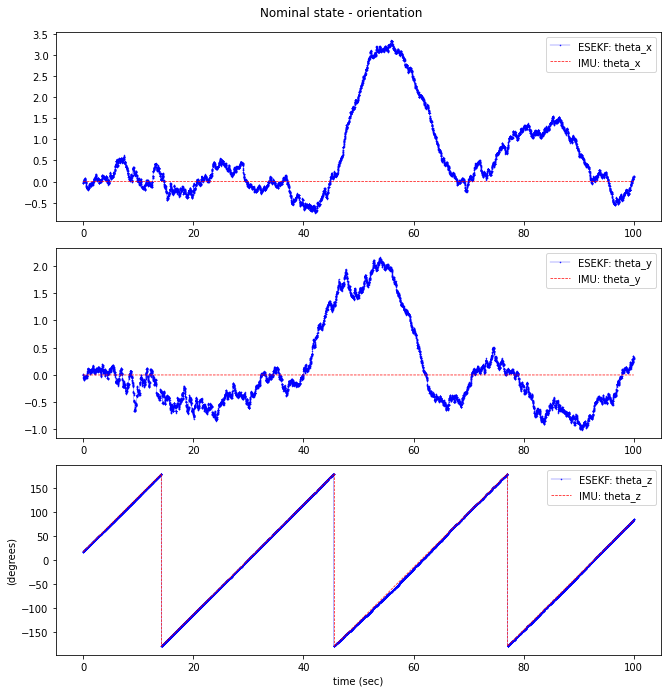

In [308]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(e_list[:,0]), 'b-o', markersize=0.5, linewidth=0.3, label="ESEKF: theta_x")
axs[1].plot(t_list, np.rad2deg(e_list[:,1]), 'b-o', markersize=0.5, linewidth=0.3, label="ESEKF: theta_y")
axs[2].plot(t_list, np.rad2deg(e_list[:,2]), 'b-o', markersize=0.5, linewidth=0.3, label="ESEKF: theta_z")
  
axs[0].plot(t_real[0:len(x_list)], np.rad2deg(orientations[0:len(x_list),0]), 'r--', 
            linewidth=0.7, label="IMU: theta_x")
axs[1].plot(t_real[0:len(x_list)], np.rad2deg(orientations[0:len(x_list),1]), 'r--', 
            linewidth=0.7, label="IMU: theta_y")
axs[2].plot(t_real[0:len(x_list)], np.rad2deg(orientations[0:len(x_list),2]), 'r--', 
            linewidth=0.7, label="IMU: theta_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(degrees)")
plt.suptitle("Nominal state - orientation")
plt.show()

#### Angular velocity - integration - CAN I?

In [309]:
dedt = np.zeros((1,3))
for i in range(1, len(t_list)):
    w = (e_list[i,:] - e_list[i-1, :])/(t_list[i] - t_list[i-1])
    dedt = np.append(dedt, [w.flatten()], axis=0)

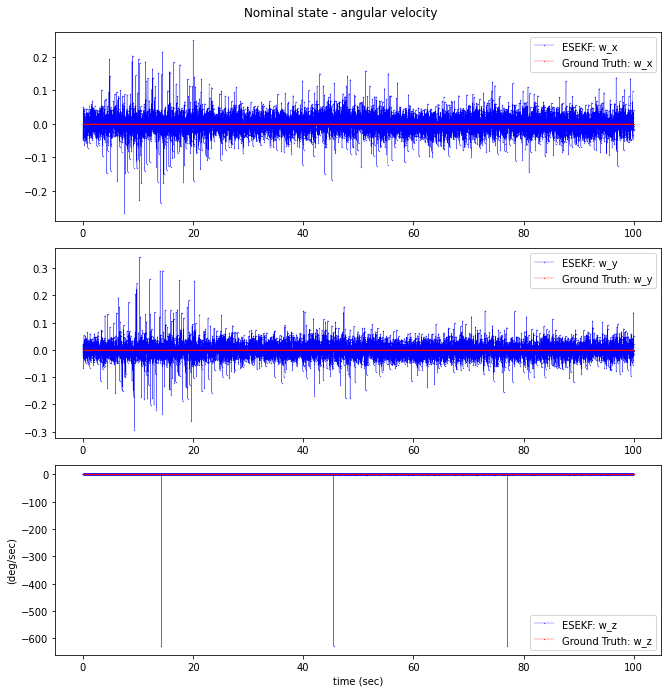

In [310]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, dedt[:,0], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_x")
axs[1].plot(t_list, dedt[:,1], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_y")
axs[2].plot(t_list, dedt[:,2], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_z")

axs[0].plot(t_real[0:len(x_list)], w_list[0:len(x_list), 0], 'r-x', 
            markersize=0.3, linewidth=0.3, label="Ground Truth: w_x")
axs[1].plot(t_real[0:len(x_list)], w_list[0:len(x_list), 1], 'r-x', 
            markersize=0.3, linewidth=0.3, label="Ground Truth: w_y")
axs[2].plot(t_real[0:len(x_list)], w_list[0:len(x_list), 2], 'r-x', 
            markersize=0.3, linewidth=0.3, label="Ground Truth: w_z")

# axs[0].plot(t_imu[0:len(x_list)], imu_w_noise[0:len(x_list),0], 'g-o', 
#             markersize=0.3, linewidth=0.6, label="IMU: w_x")
# axs[1].plot(t_imu[0:len(x_list)], imu_w_noise[0:len(x_list),1], 'g-o', 
#             markersize=0.3, linewidth=0.6, label="IMU: w_y")
# axs[2].plot(t_imu[0:len(x_list)], imu_w_noise[0:len(x_list),2], 'g-o', 
#             markersize=0.3, linewidth=0.6, label="IMU: w_z") 

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity")
plt.show()

#### Angular velocity bias

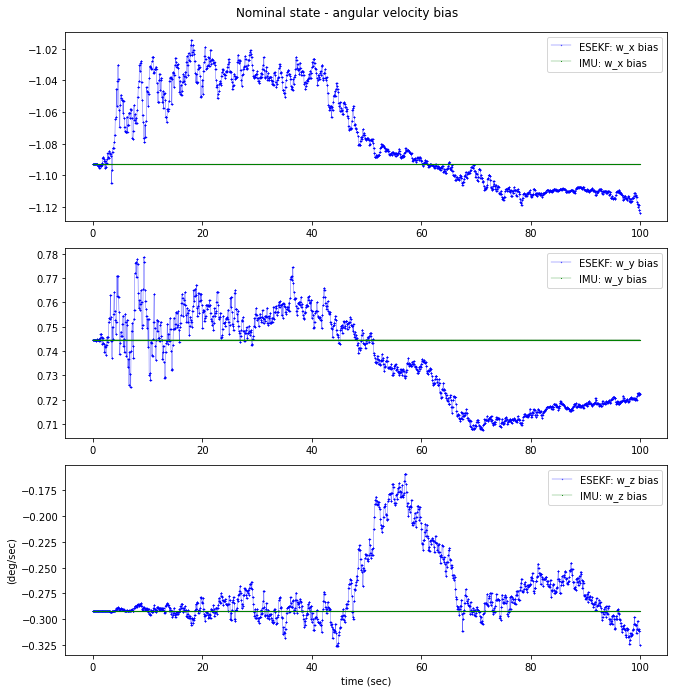

In [311]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, np.rad2deg(x_list[:,13]), 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_x bias")
axs[1].plot(t_list, np.rad2deg(x_list[:,14]), 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_y bias")
axs[2].plot(t_list, np.rad2deg(x_list[:,15]), 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: w_z bias")

axs[0].plot(t_imu[0:len(x_list)], np.rad2deg(imu_wx_bias[0:len(x_list)]), 'g-x', 
            markersize=0.3, linewidth=0.3, label="IMU: w_x bias")
axs[1].plot(t_imu[0:len(x_list)], np.rad2deg(imu_wy_bias[0:len(x_list)]), 'g-x', 
            markersize=0.3, linewidth=0.3, label="IMU: w_y bias")
axs[2].plot(t_imu[0:len(x_list)], np.rad2deg(imu_wz_bias[0:len(x_list)]), 'g-x', 
            markersize=0.3, linewidth=0.3, label="IMU: w_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(deg/sec)")
plt.suptitle("Nominal state - angular velocity bias")
plt.show()

### Translational movement

#### Position

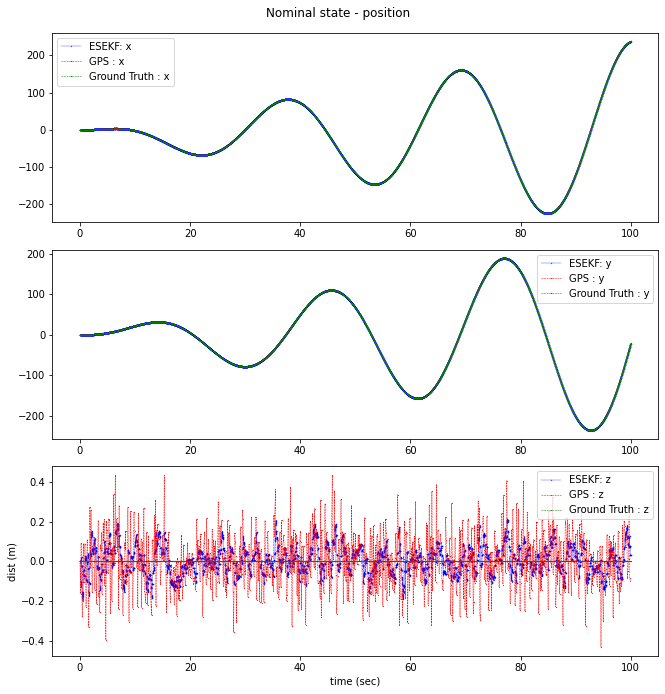

In [312]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,0], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: x")
axs[1].plot(t_list, x_list[:,1], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: y")
axs[2].plot(t_list, x_list[:,2], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: z")

axs[0].plot(t_gps, gps_noise[:,0], 'r--x', markersize=0.3, linewidth=0.5, label="GPS : x")
axs[1].plot(t_gps, gps_noise[:,1], 'r--x', markersize=0.3, linewidth=0.5, label="GPS : y")
axs[2].plot(t_gps, gps_noise[:,2], 'r--x', markersize=0.3, linewidth=0.5, label="GPS : z")

axs[0].plot(t_real, positions[:,0], 'g--x', markersize=0.3, linewidth=0.5, label="Ground Truth : x")
axs[1].plot(t_real, positions[:,1], 'g--x', markersize=0.3, linewidth=0.5, label="Ground Truth : y")
axs[2].plot(t_real, positions[:,2], 'g--x', markersize=0.3, linewidth=0.5, label="Ground Truth : z")


plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("dist (m)")
plt.suptitle("Nominal state - position")
plt.show()

#### Velocity

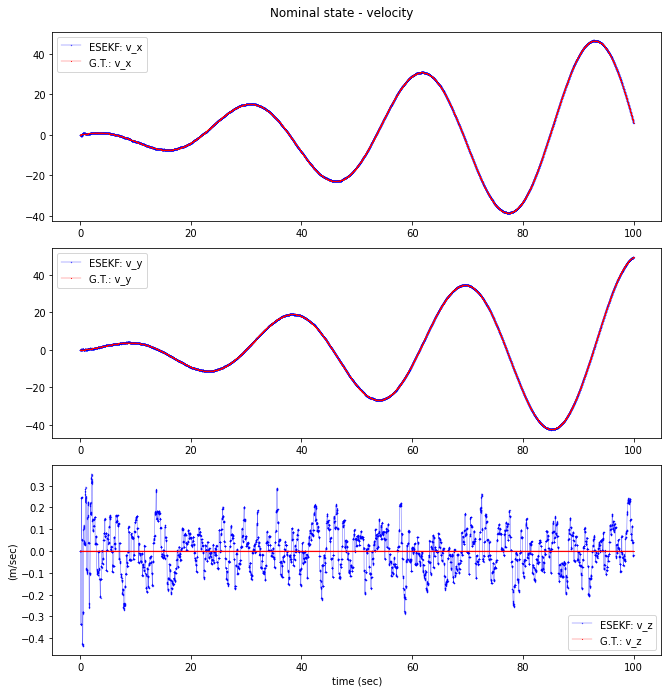

In [313]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,3], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: v_x")
axs[1].plot(t_list, x_list[:,4], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: v_y")
axs[2].plot(t_list, x_list[:,5], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: v_z")

axs[0].plot(t_real, cart_velocities_w[:,0], 'r-x', markersize=0.3, linewidth=0.3, label="G.T.: v_x")
axs[1].plot(t_real, cart_velocities_w[:,1], 'r-x', markersize=0.3, linewidth=0.3, label="G.T.: v_y")
axs[2].plot(t_real, cart_velocities_w[:,2], 'r-x', markersize=0.3, linewidth=0.3, label="G.T.: v_z")
  
plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time (sec)")
plt.ylabel("(m/sec)")
plt.suptitle("Nominal state - velocity")
plt.show()

#### Acceleration

In [314]:
dvdt_list = np.zeros((1,3))
for i in range(1, len(t_list)):
    a = (x_list[i, 3:6] - x_list[i-1, 3:6])/(t_list[i] - t_list[i-1])
    dvdt_list = np.append(dvdt_list, [a.flatten()], axis=0)

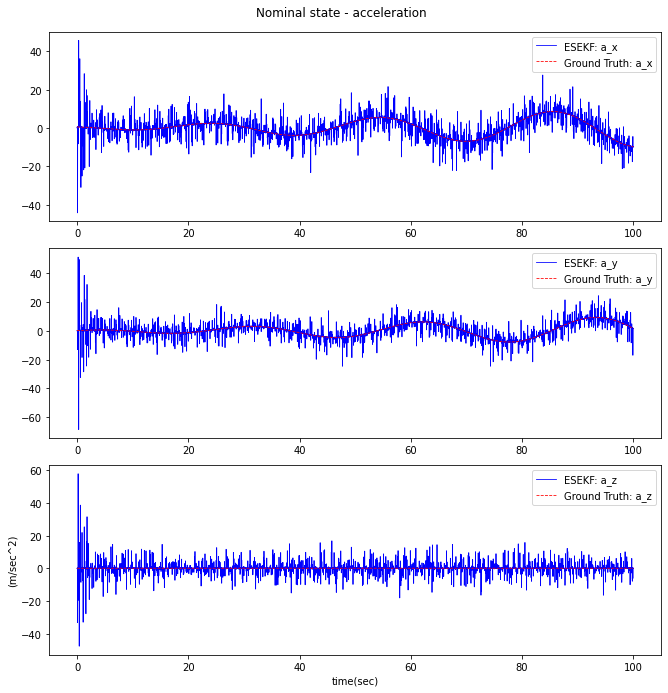

In [315]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, dvdt_list[:,0], 'b-', linewidth=0.8, label="ESEKF: a_x")
axs[1].plot(t_list, dvdt_list[:,1], 'b-', linewidth=0.8, label="ESEKF: a_y")
axs[2].plot(t_list, dvdt_list[:,2], 'b-', linewidth=0.8, label="ESEKF: a_z")

axs[0].plot(t_real[0:len(x_list)], a_list[0:len(x_list), 0], 'r--', 
            linewidth=0.8, label="Ground Truth: a_x")
axs[1].plot(t_real[0:len(x_list)], a_list[0:len(x_list), 1], 'r--', 
            linewidth=0.8, label="Ground Truth: a_y")
axs[2].plot(t_real[0:len(x_list)], a_list[0:len(x_list), 2] - GRAV, 'r--', 
            linewidth=0.8, label="Ground Truth: a_z")

# axs[0].plot(t_imu[0:len(x_list)], imu_a_noise[0:len(x_list),0], 'g-x', 
#             markersize=0.3, linewidth=0.3, label="IMU: a_x")
# axs[1].plot(t_imu[0:len(x_list)], imu_a_noise[0:len(x_list),1], 'g-x', 
#             markersize=0.3, linewidth=0.3, label="IMU: a_y")
# axs[2].plot(t_imu[0:len(x_list)], imu_a_noise[0:len(x_list),2]-GRAV, 'g-x', 
#             markersize=0.3, linewidth=0.3, label="IMU: a_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration")
plt.show()

#### Acceleration bias

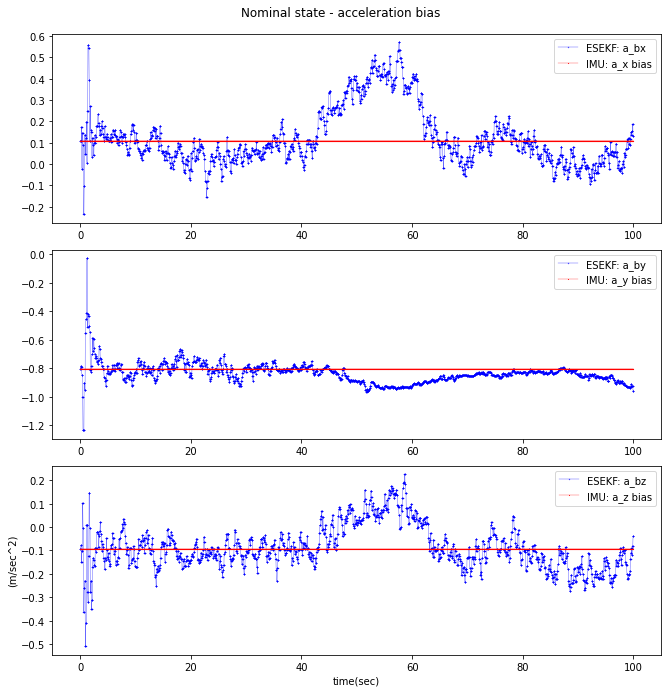

In [316]:
fig, axs = plt.subplots(3)

axs[0].plot(t_list, x_list[:,10], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_bx")
axs[1].plot(t_list, x_list[:,11], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_by")
axs[2].plot(t_list, x_list[:,12], 'b-o', markersize=0.3, linewidth=0.3, label="ESEKF: a_bz")

axs[0].plot(t_imu[0:len(x_list)], imu_ax_bias[0:len(x_list)], 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_x bias")
axs[1].plot(t_imu[0:len(x_list)], imu_ay_bias[0:len(x_list)], 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_y bias")
axs[2].plot(t_imu[0:len(x_list)], imu_az_bias[0:len(x_list)], 'r-x', 
            markersize=0.3, linewidth=0.3, label="IMU: a_z bias")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("time(sec)")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - acceleration bias")
plt.show()

### Gravity

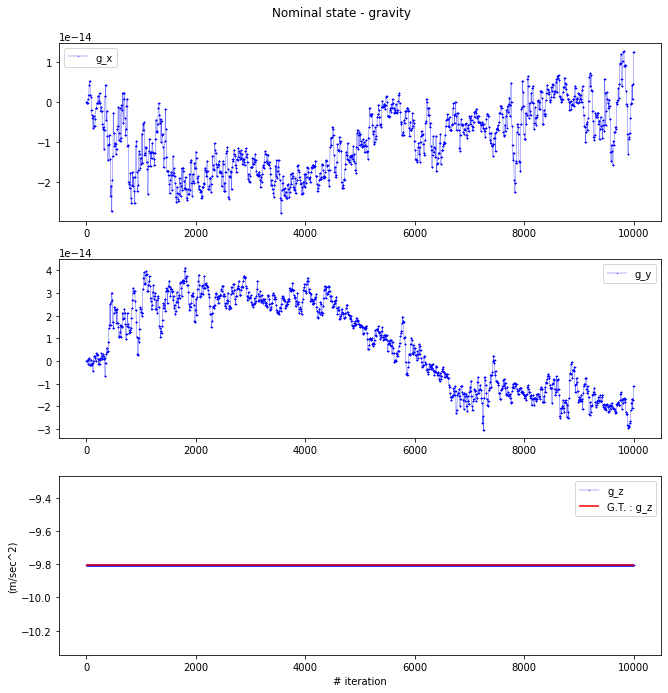

In [317]:
fig, axs = plt.subplots(3)

axs[0].plot(x_list[:,16], 'b-o', markersize=0.3, linewidth=0.3, label="g_x")
axs[1].plot(x_list[:,17], 'b-o', markersize=0.3, linewidth=0.3, label="g_y")
axs[2].plot(x_list[:,18], 'b-o', markersize=0.3, linewidth=0.3, label="g_z")
axs[2].hlines(-GRAV, 0, len(x_list), 'r', label="G.T. : g_z")

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.xlabel("# iteration")
plt.ylabel("(m/sec^2)")
plt.suptitle("Nominal state - gravity")
plt.show()

### Innovation

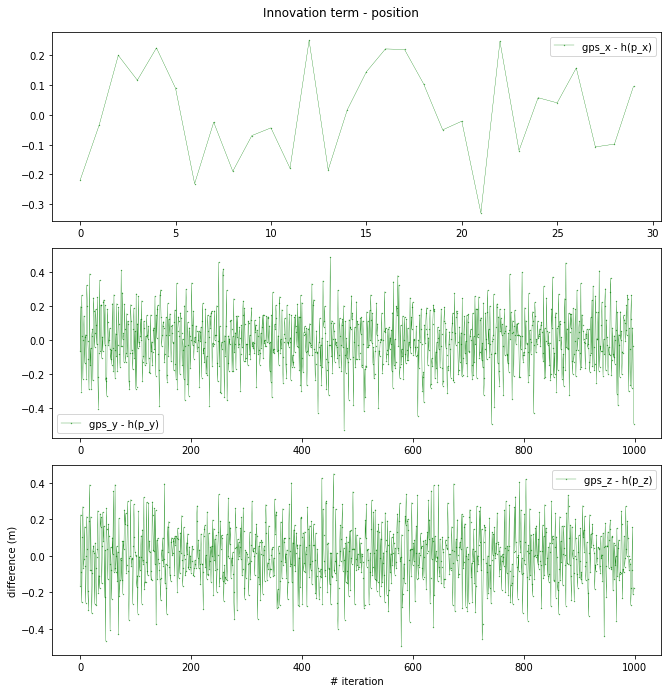

In [318]:
fig, axs = plt.subplots(3)

axs[0].plot(innovation_list[0:30,0], 'g-o', markersize=0.3, linewidth=0.3, label="gps_x - h(p_x)")
axs[1].plot(innovation_list[:,1], 'g-o', markersize=0.3, linewidth=0.3, label="gps_y - h(p_y)")
axs[2].plot(innovation_list[:,2], 'g-o', markersize=0.3, linewidth=0.3, label="gps_z - h(p_z)")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("difference (m)")
plt.xlabel("# iteration")
fig.suptitle("Innovation term - position")
plt.show()

### Error state

#### Position

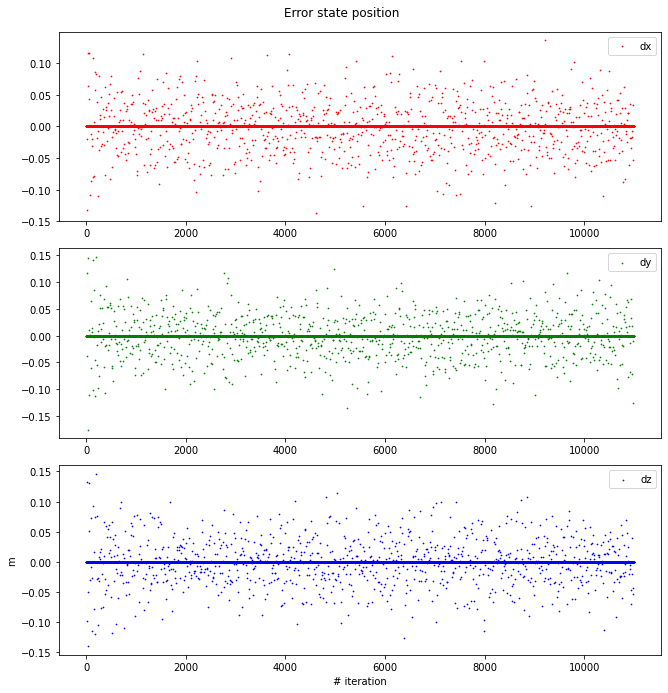

In [319]:
fig, axs = plt.subplots(3)

t = np.arange(len(dx_list))

axs[0].scatter(t, dx_list[:,0], marker='o', color='r', s=.5, label="dx")
axs[1].scatter(t, dx_list[:,1], marker='o', color='g', s=.5, label="dy")
axs[2].scatter(t, dx_list[:,2], marker='o', color='b', s=.5, label="dz")
  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("m")
plt.xlabel("# iteration")
fig.suptitle("Error state position")
plt.show()

#### Orientation

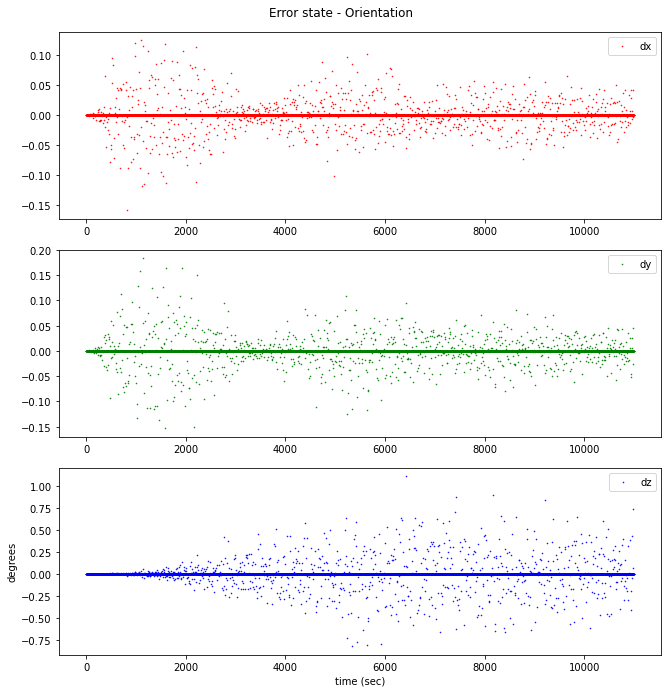

In [320]:
fig, axs = plt.subplots(3)

t = np.arange(len(dx_list))

axs[0].scatter(t, np.rad2deg(dx_list[:,6]), marker='o', color='r', s=0.3, label="dx")
axs[1].scatter(t, np.rad2deg(dx_list[:,7]), marker='o', color='g', s=0.3, label="dy")
axs[2].scatter(t, np.rad2deg(dx_list[:,8]), marker='o', color='b', s=0.3, label="dz")  

plt.tight_layout(pad=4, w_pad=0, h_pad=1)
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Set common labels
plt.ylabel("degrees")
plt.xlabel("time (sec)")
fig.suptitle("Error state - Orientation")
plt.show()

## Trajectory in 2d

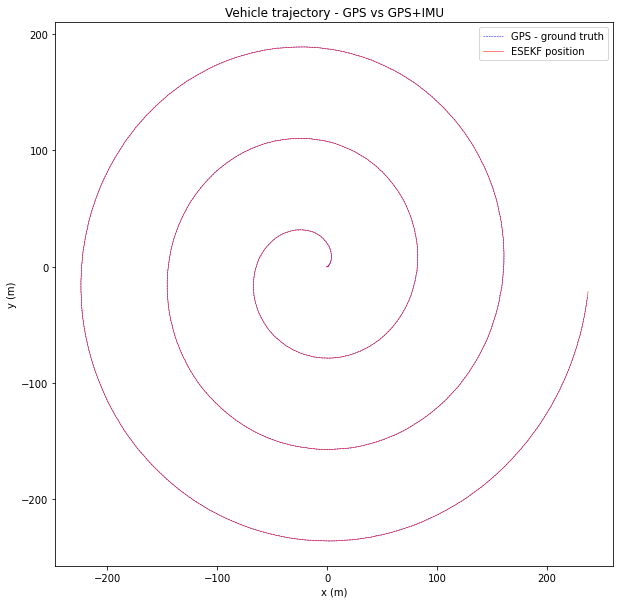

In [321]:
plt.plot(gps_noise[:,0], gps_noise[:,1], 'b--', linewidth=0.5, label = "GPS - ground truth")
plt.plot(x_list[:,0], x_list[:,1], 'r-', linewidth=0.5, label = "ESEKF position")
plt.title("Vehicle trajectory - GPS vs GPS+IMU")

plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


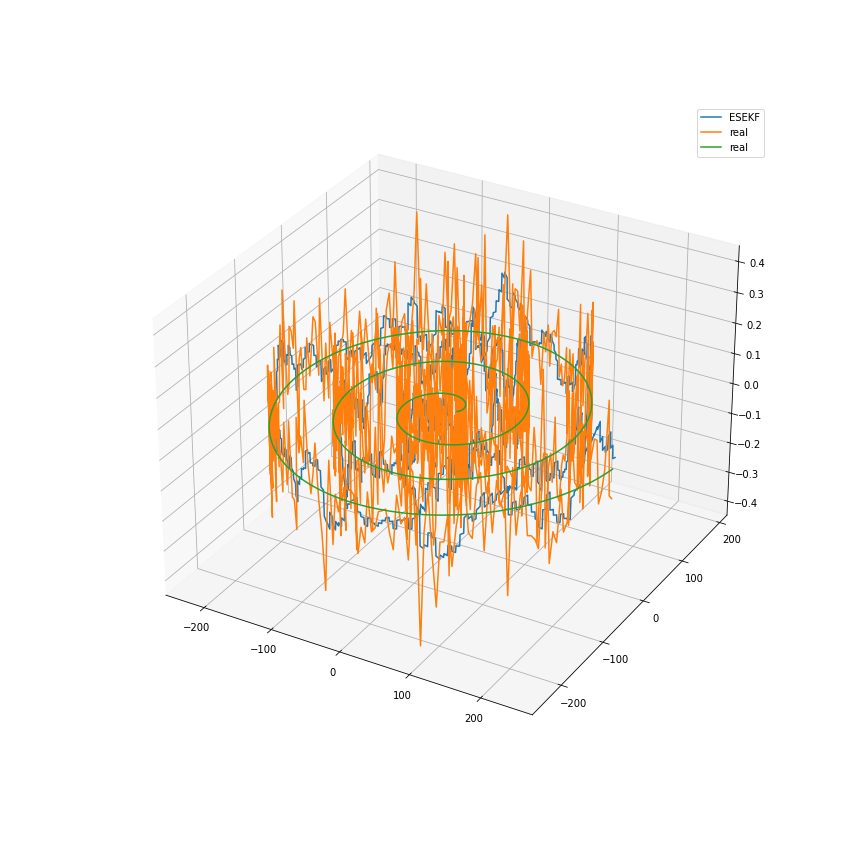

In [322]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (12,12)

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(x_list[:,0], x_list[:,1], x_list[:,2], label="ESEKF")
ax.plot(gps_noise[:,0], gps_noise[:,1], gps_noise[:,2], label="real")
ax.plot(gps[:,0], gps[:,1], gps[:,2], label="real")

plt.legend()
plt.show()